# New York Taxi-Cab: Deep Learning Time Series Prediction Modeling and Business Case Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import tqdm as notebook_tqdm
import seaborn as sb
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import matplotlib.pyplot as plt

import sys
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras

from pandas import DataFrame
from pandas import concat

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
import csv

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import sklearn as sk

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# What version of Python do you have?
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.15 (main, Nov  4 2022, 16:35:55) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.4
Scikit-Learn 1.1.3
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [3]:
#df_EDA = pd.read_csv('yellow_tripdata_2021_01_outfile.csv')
df_EDA = pd.read_csv('yellow_tripdata_2021_01_outfile_notime.csv')

# 🧹 **Inspection, Cleaning, Feature Engineering, and Data Exploration of Data**

In [4]:
df_EDA.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,0,1,2021-01-01,2021-01-01 0:36,1,2.10,1,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,1,2021-01-01,2021-01-01 0:52,1,0.20,1,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,2,1,2021-01-01,2021-01-01 1:11,1,14.70,1,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,3,1,2021-01-01,2021-01-01 0:31,0,10.60,1,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,4,2,2021-01-01,2021-01-01 0:48,1,4.94,1,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [5]:
# Lets see what the data types for each column is
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1048575 non-null  int64  
 1   VendorID               1048575 non-null  int64  
 2   tpep_pickup_datetime   1048575 non-null  object 
 3   tpep_dropoff_datetime  1048575 non-null  object 
 4   passenger_count        1048575 non-null  int64  
 5   trip_distance          1048575 non-null  float64
 6   RatecodeID             1048575 non-null  int64  
 7   store_and_fwd_flag     1048575 non-null  object 
 8   PULocationID           1048575 non-null  int64  
 9   DOLocationID           1048575 non-null  int64  
 10  payment_type           1048575 non-null  int64  
 11  fare_amount            1048575 non-null  float64
 12  extra                  1048575 non-null  float64
 13  mta_tax                1048575 non-null  float64
 14  tip_amount        

In [6]:
# Finding Null values
df_EDA.isnull().sum()

Unnamed: 0                     0
VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge           0
airport_fee              1048570
dtype: int64

In [7]:
# Dropping columns that are not usefull
df_EDA = df_EDA.drop(['Unnamed: 0', 'airport_fee'], axis=1)

### 🧹 **Changing the values of categorical columns so that it is easier to understand.**

In [8]:
df_EDA['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

In [9]:
df_EDA.loc[df_EDA['store_and_fwd_flag'].str.contains(r'N', case = False, na = False), 'store_and_fwd_flag'] = 'No'
df_EDA.loc[df_EDA['store_and_fwd_flag'].str.contains(r'Y', case = False, na = False), 'store_and_fwd_flag'] = 'Yes'

In [10]:
df_EDA['store_and_fwd_flag'].unique()

array(['No', 'Yes'], dtype=object)

In [11]:
df_EDA['RatecodeID'].unique()

array([ 1,  2,  4,  5,  3, 99,  6], dtype=int64)

In [12]:
df_EDA['RatecodeID'] = df_EDA['RatecodeID'].astype(str)

In [13]:
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'1', case = False, na = False), 'RatecodeID'] = 'Standard_rate'
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'2', case = False, na = False), 'RatecodeID'] = 'JFK'
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'3', case = False, na = False), 'RatecodeID'] = 'Newark'
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'4', case = False, na = False), 'RatecodeID'] = 'Nassau_or_Westchester'
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'5', case = False, na = False), 'RatecodeID'] = 'Negotiated_fare'
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'6', case = False, na = False), 'RatecodeID'] = 'Group_ride'
df_EDA.loc[df_EDA['RatecodeID'].str.contains(r'99', case = False, na = False), 'RatecodeID'] = 'Other'

In [14]:
df_EDA['RatecodeID'].unique()

array(['Standard_rate', 'JFK', 'Nassau_or_Westchester', 'Negotiated_fare',
       'Newark', 'Other', 'Group_ride'], dtype=object)

In [15]:
df_EDA['payment_type'].unique()

array([2, 1, 4, 3], dtype=int64)

In [16]:
df_EDA['payment_type'] = df_EDA['payment_type'].astype(str)

In [17]:
df_EDA.loc[df_EDA['payment_type'].str.contains(r'1', case = False, na = False), 'payment_type'] = 'Credit_card'
df_EDA.loc[df_EDA['payment_type'].str.contains(r'2', case = False, na = False), 'payment_type'] = 'Cash'
df_EDA.loc[df_EDA['payment_type'].str.contains(r'3', case = False, na = False), 'payment_type'] = 'No_charge'
df_EDA.loc[df_EDA['payment_type'].str.contains(r'4', case = False, na = False), 'payment_type'] = 'Dispute'

In [18]:
df_EDA['payment_type'].unique()

array(['Cash', 'Credit_card', 'Dispute', 'No_charge'], dtype=object)

In [19]:
df_EDA['VendorID'].unique()

array([1, 2], dtype=int64)

In [20]:
df_EDA['VendorID'] = df_EDA['VendorID'].astype(str)

In [21]:
df_EDA.loc[df_EDA['VendorID'].str.contains(r'1', case = False, na = False), 'VendorID'] = 'Creative Mobile Technologies'
df_EDA.loc[df_EDA['VendorID'].str.contains(r'2', case = False, na = False), 'VendorID'] = 'VeriFone Inc.'

In [22]:
df_EDA['VendorID'].unique()

array(['Creative Mobile Technologies', 'VeriFone Inc.'], dtype=object)

array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'PULocationID'}>],
       [<AxesSubplot:title={'center':'DOLocationID'}>,
        <AxesSubplot:title={'center':'fare_amount'}>,
        <AxesSubplot:title={'center':'extra'}>],
       [<AxesSubplot:title={'center':'mta_tax'}>,
        <AxesSubplot:title={'center':'tip_amount'}>,
        <AxesSubplot:title={'center':'tolls_amount'}>],
       [<AxesSubplot:title={'center':'improvement_surcharge'}>,
        <AxesSubplot:title={'center':'total_amount'}>,
        <AxesSubplot:title={'center':'congestion_surcharge'}>]],
      dtype=object)

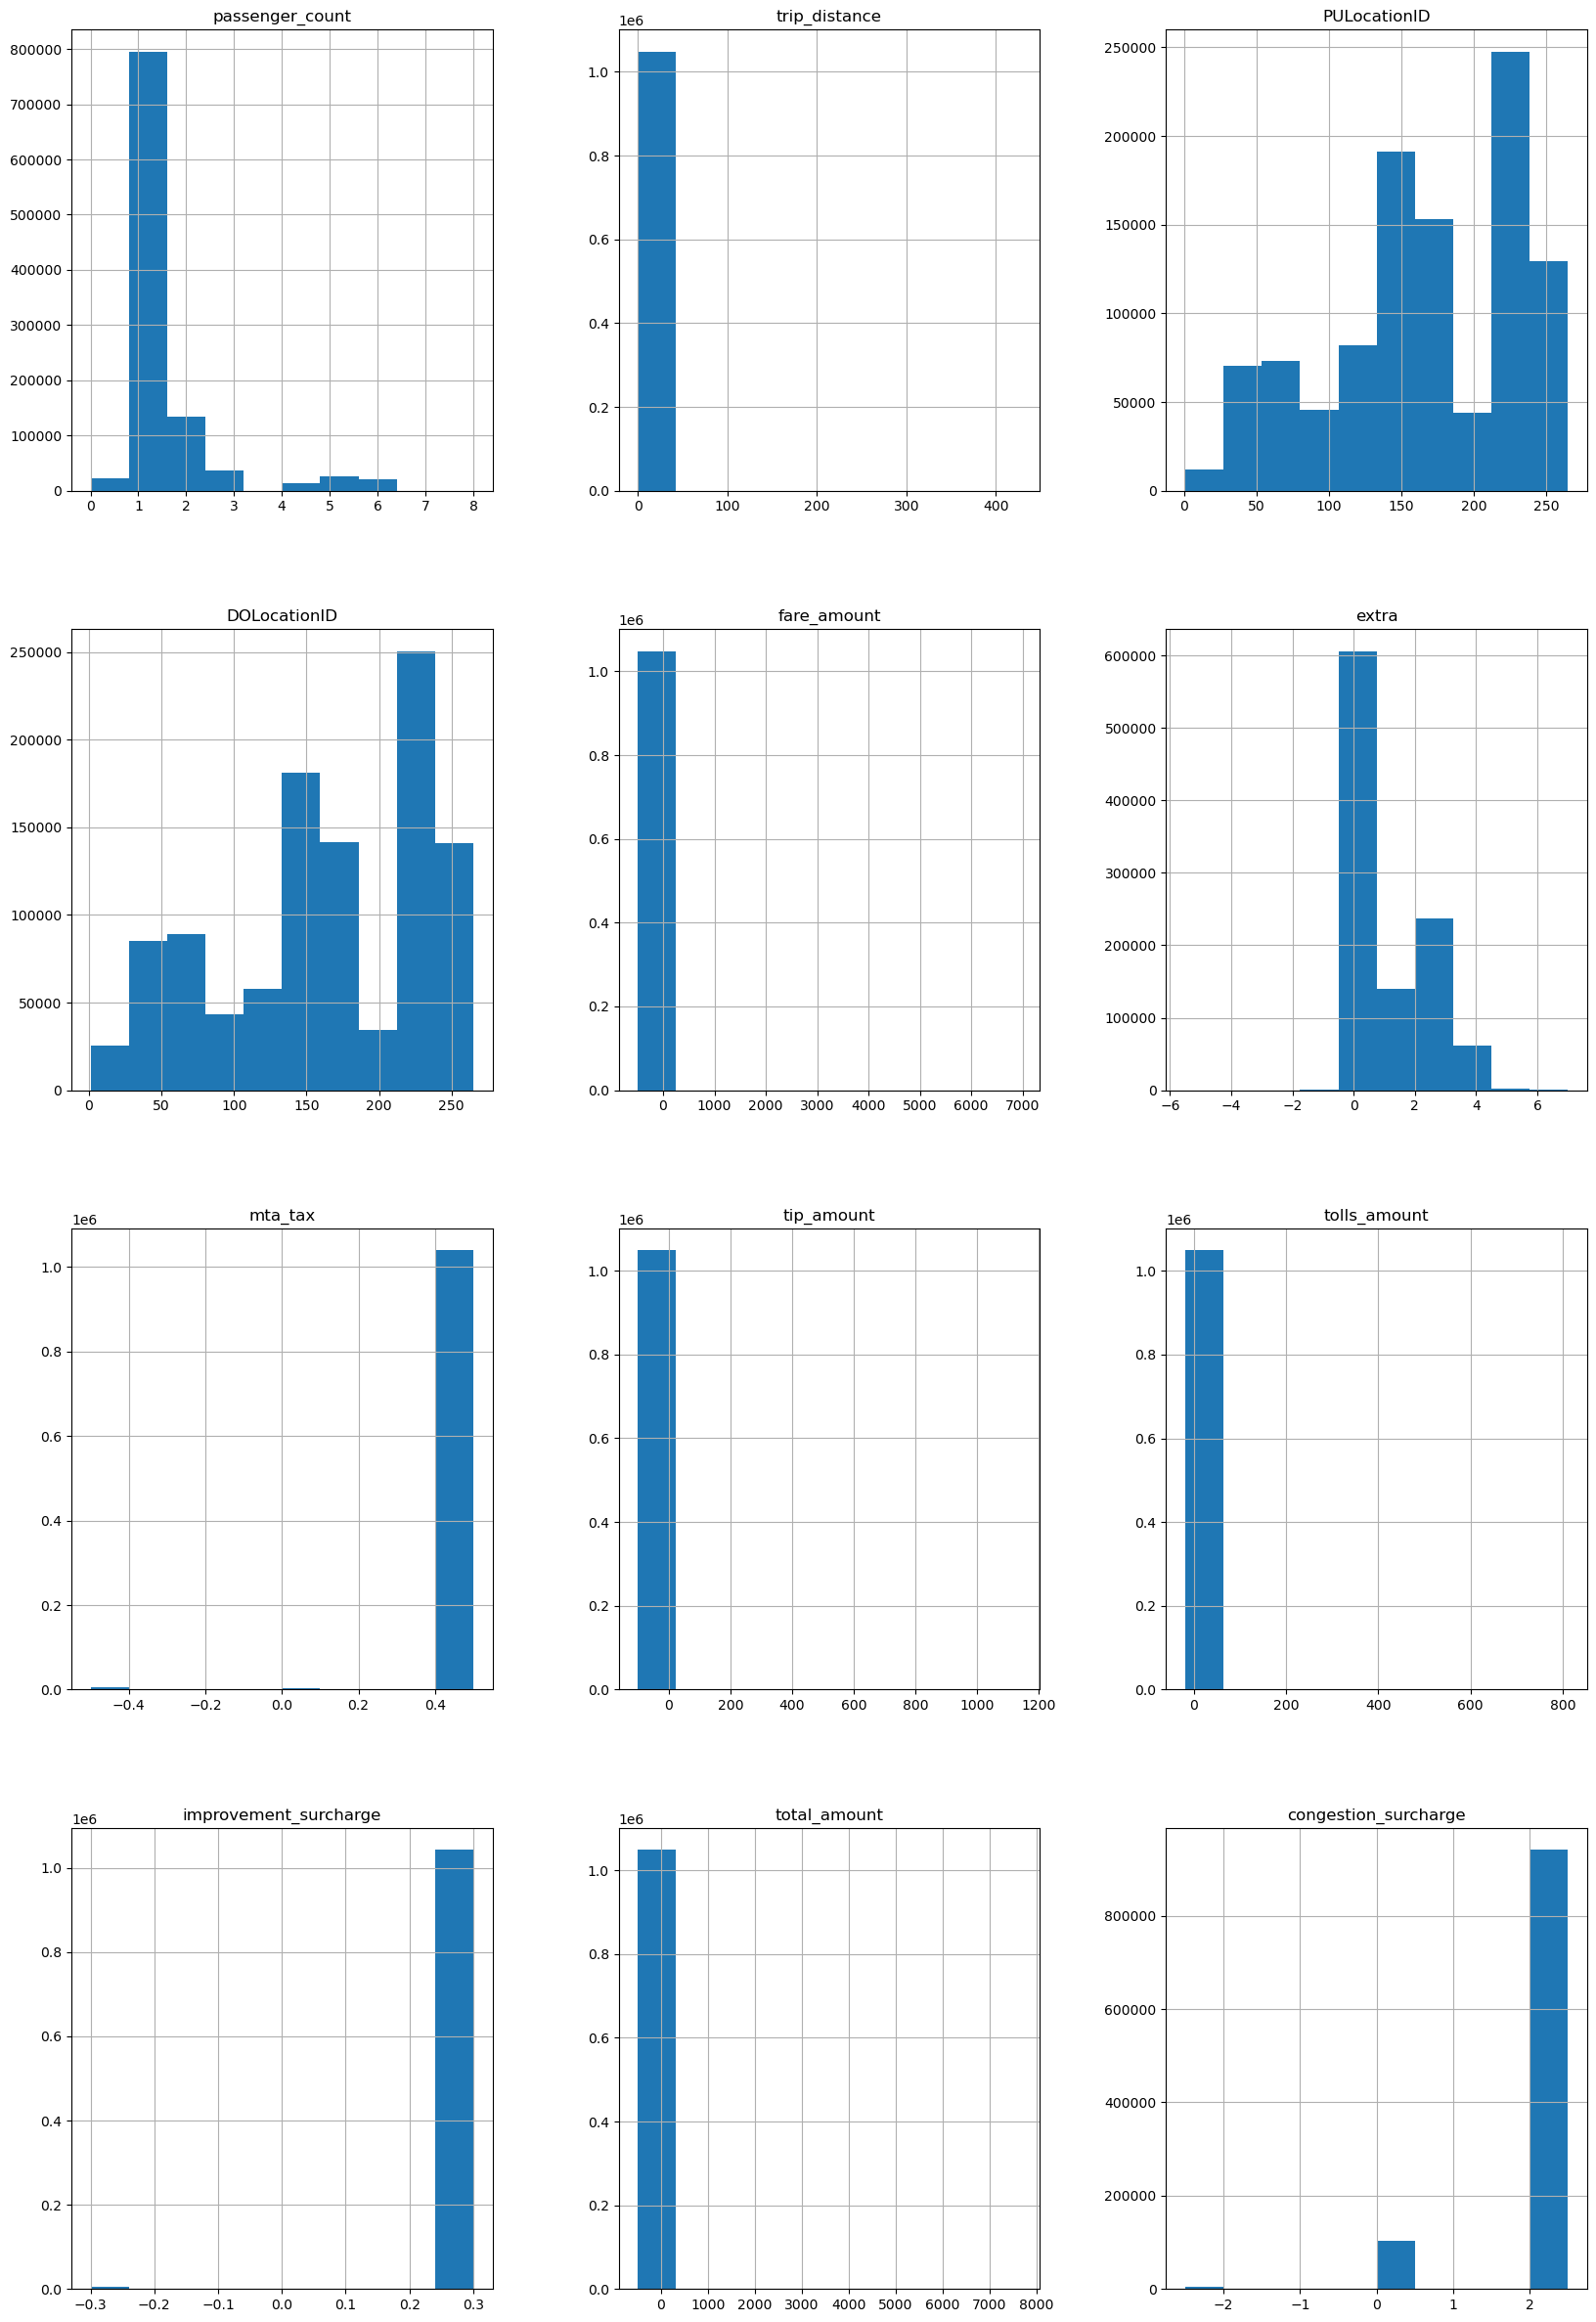

In [23]:
df_EDA.hist(figsize = (20,30))

**The histograms show us interesting information about our dataset. We have some negative values for the following columns:**
- **extra**
- **mta_tax**
- **improvement_surcharge**
- **congestion_surcharge**
- **airport_fee**

**Not all of the histograms are important such as:**
- RatecodeID
- PuLocationID
- DOLocationID
- Untitled

**We can also see some useful information regarding the count for the following features such as:**
- payment_type - *the top 2 payment methods are by **Credit Cards (1)** and **Cash (2)**.*
- VendorID - *Vendor 2 has more recorded trips than Vendor 1*
- passenger_count - *majority of the trips consist of fewer than 3 customers at a time*
- trip_distance - *shorter distance trips are far more popular than longer distance trips.*

**There are some outlier issues with this dataset. Here are 2 examples:**
- fare_amount
- total_amount

### 🧹 **To see the overall data, we can try to find the *min, max, median, and mean* of each column that are continuous. This will help us identify outliers and irregularties with the informtion in our dataset.**

In [24]:
# Min, max, median, mean before data cleaning
df_EDA.groupby('VendorID').agg({'total_amount': ['min', 'max', 'median', 'mean'],
                          'trip_distance': ['min', 'max', 'median', 'mean'],
                          'passenger_count': ['min', 'max', 'median', 'mean'],
                          'fare_amount': ['min', 'max', 'median', 'mean'],
                          'extra': ['min', 'max', 'median', 'mean']})

total_amount                             \
                                      min      max median       mean   
VendorID                                                               
Creative Mobile Technologies          0.0  2292.40   13.5  16.602635   
VeriFone Inc.                      -492.8  7661.28   13.5  16.460939   

                             trip_distance                           \
                                       min     max median      mean   
VendorID                                                              
Creative Mobile Technologies           0.0  427.70   1.60  2.532970   
VeriFone Inc.                          0.0  215.95   1.65  2.689165   

                             passenger_count                      fare_amount  \
                                         min max median      mean         min   
VendorID                                                                        
Creative Mobile Technologies               0   6    1.0  1.116243         0.0   
VeriFone Inc.                              0   8    1.0  1.555658      -490.0   

                                                       extra              \
                                 max median       mean   min  max median   
VendorID                                                                   
Creative Mobile Technologies  1128.5    8.5  11.246850   0.0  7.0    2.5   
VeriFone Inc.                 6960.5    8.0  11.019588  -5.5  5.5    0.0   

                                        
                                  mean  
VendorID                                
Creative Mobile Technologies  2.491883  
VeriFone Inc.                 0.256200

In [25]:
df_EDA.drop(df_EDA[df_EDA['total_amount'] == 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['total_amount'] < 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['trip_distance'] == 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['total_amount'] > 600].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['fare_amount'] > 600].index, axis=0, inplace = True)

In [26]:
# Min, max, median, mean after data cleaning
df_EDA.groupby('VendorID').agg({'total_amount': ['min', 'max', 'median', 'mean'],
                          'trip_distance': ['min', 'max', 'median', 'mean'],
                          'passenger_count': ['min', 'max', 'median', 'mean'],
                          'fare_amount': ['min', 'max', 'median', 'mean'],
                          'extra': ['min', 'max', 'median', 'mean']})

total_amount                            \
                                      min     max median       mean   
VendorID                                                              
Creative Mobile Technologies         0.01  523.86  13.35  16.358014   
VeriFone Inc.                        0.89  525.21  13.53  16.624334   

                             trip_distance                           \
                                       min     max median      mean   
VendorID                                                              
Creative Mobile Technologies          0.10  153.10   1.60  2.612141   
VeriFone Inc.                         0.01  167.08   1.67  2.712102   

                             passenger_count                      fare_amount  \
                                         min max median      mean         min   
VendorID                                                                        
Creative Mobile Technologies               0   6    1.0  1.119413        0.00   
VeriFone Inc.                              0   7    1.0  1.558398        0.02   

                                                      extra              \
                                max median       mean   min  max median   
VendorID                                                                  
Creative Mobile Technologies  418.5    8.0  10.914394   0.0  7.0    2.5   
VeriFone Inc.                 484.0    8.5  11.112050   0.0  5.5    0.0   

                                        
                                  mean  
VendorID                                
Creative Mobile Technologies  2.561211  
VeriFone Inc.                 0.260973

In [27]:
# Min, max, median, mean before data cleaning
df_EDA.groupby('VendorID').agg({'mta_tax': ['min', 'max', 'median', 'mean'],
                          'improvement_surcharge': ['min', 'max', 'median', 'mean'],
                          'tip_amount': ['min', 'max', 'median', 'mean'],
                          'tolls_amount': ['min', 'max', 'median', 'mean']})

mta_tax                        \
                                 min  max median      mean   
VendorID                                                     
Creative Mobile Technologies     0.0  0.5    0.5  0.498471   
VeriFone Inc.                    0.0  0.5    0.5  0.499281   

                             improvement_surcharge                        \
                                               min  max median      mean   
VendorID                                                                   
Creative Mobile Technologies                   0.0  0.3    0.3  0.299999   
VeriFone Inc.                                  0.0  0.3    0.3  0.299984   

                             tip_amount                         tolls_amount  \
                                    min    max median      mean          min   
VendorID                                                                       
Creative Mobile Technologies        0.0  145.0   1.85  1.914817          0.0   
VeriFone Inc.                       0.0  333.0   1.86  1.983253          0.0   

                                                      
                                max median      mean  
VendorID                                              
Creative Mobile Technologies  60.00    0.0  0.169122  
VeriFone Inc.                 58.75    0.0  0.184203

In [28]:
df_EDA.drop(df_EDA[df_EDA['mta_tax'] < 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['improvement_surcharge'] < 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['tip_amount'] > 200].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['tip_amount'] < 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['tolls_amount'] < 0].index, axis=0, inplace = True)
df_EDA.drop(df_EDA[df_EDA['fare_amount'] > 85].index, axis=0, inplace = True)

In [29]:
# Min, max, median, mean after data cleaning
df_EDA.groupby('VendorID').agg({'mta_tax': ['min', 'max', 'median', 'mean'],
                          'improvement_surcharge': ['min', 'max', 'median', 'mean'],
                          'tip_amount': ['min', 'max', 'median', 'mean'],
                          'tolls_amount': ['min', 'max', 'median', 'mean']})

mta_tax                        \
                                 min  max median      mean   
VendorID                                                     
Creative Mobile Technologies     0.0  0.5    0.5  0.498699   
VeriFone Inc.                    0.0  0.5    0.5  0.499438   

                             improvement_surcharge                        \
                                               min  max median      mean   
VendorID                                                                   
Creative Mobile Technologies                   0.0  0.3    0.3  0.299999   
VeriFone Inc.                                  0.0  0.3    0.3  0.299984   

                             tip_amount                          tolls_amount  \
                                    min     max median      mean          min   
VendorID                                                                        
Creative Mobile Technologies        0.0  145.00   1.85  1.909458          0.0   
VeriFone Inc.                       0.0  111.41   1.86  1.974266          0.0   

                                                      
                                max median      mean  
VendorID                                              
Creative Mobile Technologies  60.00    0.0  0.163377  
VeriFone Inc.                 58.75    0.0  0.174152

In [30]:
df_EDA.groupby('VendorID').agg({'congestion_surcharge': ['min', 'max', 'median', 'mean']})

congestion_surcharge                      
                                              min  max median      mean
VendorID                                                               
Creative Mobile Technologies                  0.0  2.5    2.5  2.282936
VeriFone Inc.                                 0.0  2.5    2.5  2.285226

In [31]:
df_EDA.drop(df_EDA[df_EDA['mta_tax'] < 0].index, axis=0, inplace = True)

In [32]:
df_EDA.groupby('VendorID').agg({'congestion_surcharge': ['min', 'max', 'median', 'mean']})

congestion_surcharge                      
                                              min  max median      mean
VendorID                                                               
Creative Mobile Technologies                  0.0  2.5    2.5  2.282936
VeriFone Inc.                                 0.0  2.5    2.5  2.285226

📍 **There are some incorrect dates in the dataset that I noticed while looking at the Excel file. I decided to remove these rows, which won't have a large impact because there were only a few of these.**

In [33]:
df_EDA.drop(df_EDA[df_EDA['tpep_pickup_datetime'] < '2020-12-31 00:00:00'].index, axis=0, inplace = True)

In [34]:
df_EDA.drop(df_EDA[df_EDA['tpep_pickup_datetime'] > '2021-01-31 00:00:00'].index, axis=0, inplace = True)

array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'PULocationID'}>],
       [<AxesSubplot:title={'center':'DOLocationID'}>,
        <AxesSubplot:title={'center':'fare_amount'}>,
        <AxesSubplot:title={'center':'extra'}>],
       [<AxesSubplot:title={'center':'mta_tax'}>,
        <AxesSubplot:title={'center':'tip_amount'}>,
        <AxesSubplot:title={'center':'tolls_amount'}>],
       [<AxesSubplot:title={'center':'improvement_surcharge'}>,
        <AxesSubplot:title={'center':'total_amount'}>,
        <AxesSubplot:title={'center':'congestion_surcharge'}>]],
      dtype=object)

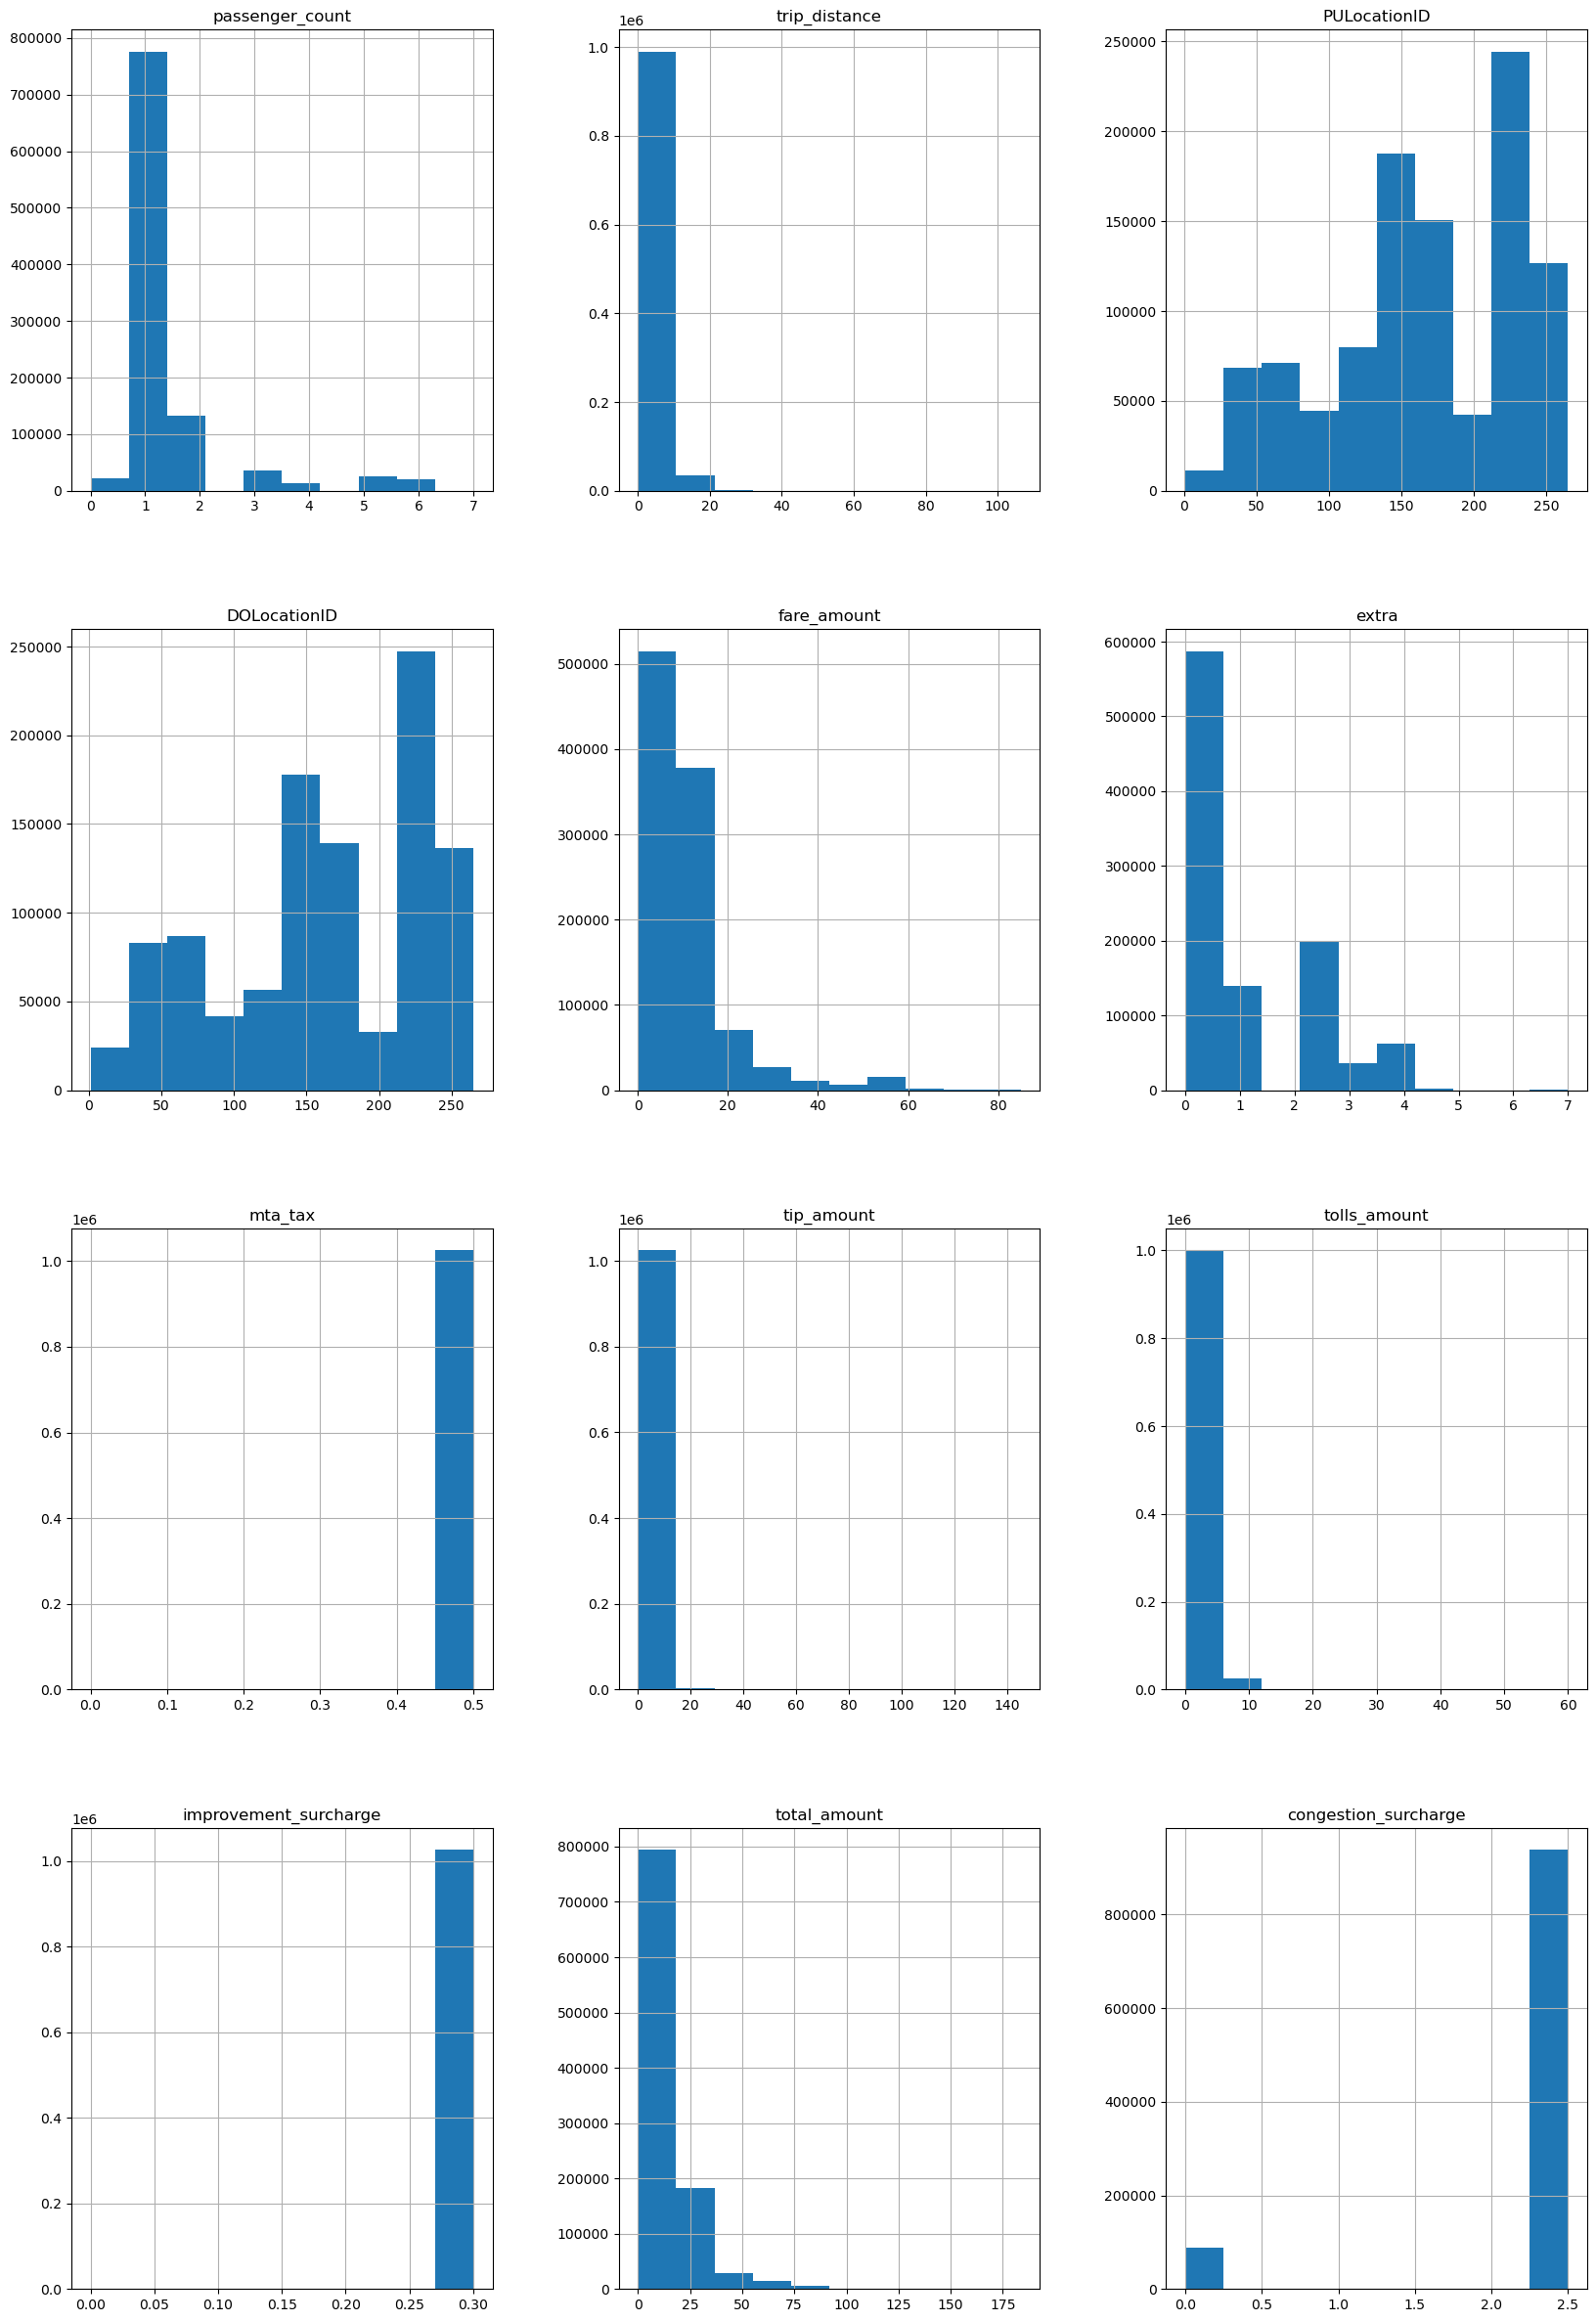

In [35]:
df_EDA.hist(figsize = (20,30))

> **We can see there is improvement with the abve data clearning steps.** 

### 📊 **Let's take a look at how the two Vendors stack up to each other from a *high level* approach.**

> 📍 The `groupby` functions allows us to create a group by table which stacks the results we are trying to compare. Typically, you would make a pivot table and use the `pivot_table` function, but the `groupby` function here works just as well.

In [36]:
df_EDA.groupby(['VendorID','store_and_fwd_flag'])['passenger_count'].count()

VendorID                      store_and_fwd_flag
Creative Mobile Technologies  No                    312129
                              Yes                    14618
VeriFone Inc.                 No                    699391
                              Yes                      325
Name: passenger_count, dtype: int64

In [37]:
df_EDA.groupby(['VendorID','RatecodeID'])['passenger_count'].count()

VendorID                      RatecodeID           
Creative Mobile Technologies  Group_ride                    2
                              JFK                        3865
                              Nassau_or_Westchester       260
                              Negotiated_fare             577
                              Newark                      143
                              Standard_rate            321900
VeriFone Inc.                 JFK                        8502
                              Nassau_or_Westchester       472
                              Negotiated_fare             978
                              Newark                      364
                              Other                        11
                              Standard_rate            689389
Name: passenger_count, dtype: int64

In [38]:
df_EDA.groupby(['VendorID','payment_type'])['passenger_count'].count()

VendorID                      payment_type
Creative Mobile Technologies  Cash             82720
                              Credit_card     238140
                              Dispute           1657
                              No_charge         4230
VeriFone Inc.                 Cash            181970
                              Credit_card     517746
Name: passenger_count, dtype: int64

In [39]:
df_EDA.groupby(['VendorID','payment_type'])['total_amount'].count()

VendorID                      payment_type
Creative Mobile Technologies  Cash             82720
                              Credit_card     238140
                              Dispute           1657
                              No_charge         4230
VeriFone Inc.                 Cash            181970
                              Credit_card     517746
Name: total_amount, dtype: int64

In [40]:
df_EDA.groupby(['VendorID','store_and_fwd_flag'])['total_amount'].count()

VendorID                      store_and_fwd_flag
Creative Mobile Technologies  No                    312129
                              Yes                    14618
VeriFone Inc.                 No                    699391
                              Yes                      325
Name: total_amount, dtype: int64

In [41]:
df_EDA.groupby(['VendorID','RatecodeID'])['total_amount'].count()

VendorID                      RatecodeID           
Creative Mobile Technologies  Group_ride                    2
                              JFK                        3865
                              Nassau_or_Westchester       260
                              Negotiated_fare             577
                              Newark                      143
                              Standard_rate            321900
VeriFone Inc.                 JFK                        8502
                              Nassau_or_Westchester       472
                              Negotiated_fare             978
                              Newark                      364
                              Other                        11
                              Standard_rate            689389
Name: total_amount, dtype: int64

In [42]:
df_EDA.groupby(['VendorID','payment_type'])['total_amount'].median()

VendorID                      payment_type
Creative Mobile Technologies  Cash            11.30
                              Credit_card     14.10
                              Dispute         11.30
                              No_charge       11.30
VeriFone Inc.                 Cash            11.30
                              Credit_card     14.16
Name: total_amount, dtype: float64

In [43]:
df_EDA.groupby(['VendorID','payment_type'])['fare_amount'].median()

VendorID                      payment_type
Creative Mobile Technologies  Cash            8.0
                              Credit_card     8.5
                              Dispute         8.0
                              No_charge       8.0
VeriFone Inc.                 Cash            8.0
                              Credit_card     8.5
Name: fare_amount, dtype: float64

### 📊 **Graphing the above `groupby` tables for visualization**

In [44]:
df1 = df_EDA.copy()

In [45]:
df1 = df1.set_index(['VendorID'])

In [46]:
df1

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
VendorID,,,,,,,,,,,,,,,,,
Creative Mobile Technologies,2021-01-01,2021-01-01 0:36,1,2.10,Standard_rate,No,142,43,Cash,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
Creative Mobile Technologies,2021-01-01,2021-01-01 0:52,1,0.20,Standard_rate,No,238,151,Cash,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
Creative Mobile Technologies,2021-01-01,2021-01-01 1:11,1,14.70,Standard_rate,No,132,165,Credit_card,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
Creative Mobile Technologies,2021-01-01,2021-01-01 0:31,0,10.60,Standard_rate,No,138,132,Credit_card,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
VeriFone Inc.,2021-01-01,2021-01-01 0:48,1,4.94,Standard_rate,No,68,33,Credit_card,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VeriFone Inc.,2021-01-26,2021-01-26 19:37,1,1.83,Standard_rate,No,79,234,Credit_card,9.0,1.0,0.5,2.66,0.0,0.3,15.96,2.5
VeriFone Inc.,2021-01-26,2021-01-26 19:46,6,3.81,Standard_rate,No,262,42,Cash,14.5,1.0,0.5,0.00,0.0,0.3,18.80,2.5
VeriFone Inc.,2021-01-26,2021-01-26 20:00,6,0.98,Standard_rate,No,263,262,Credit_card,5.5,1.0,0.5,1.96,0.0,0.3,11.76,2.5


In [47]:
df2 = df1.groupby(['VendorID','payment_type'])['fare_amount'].count().unstack('payment_type')
df2

payment_type,Cash,Credit_card,Dispute,No_charge
VendorID,,,,
Creative Mobile Technologies,82720.0,238140.0,1657.0,4230.0
VeriFone Inc.,181970.0,517746.0,NaN,NaN


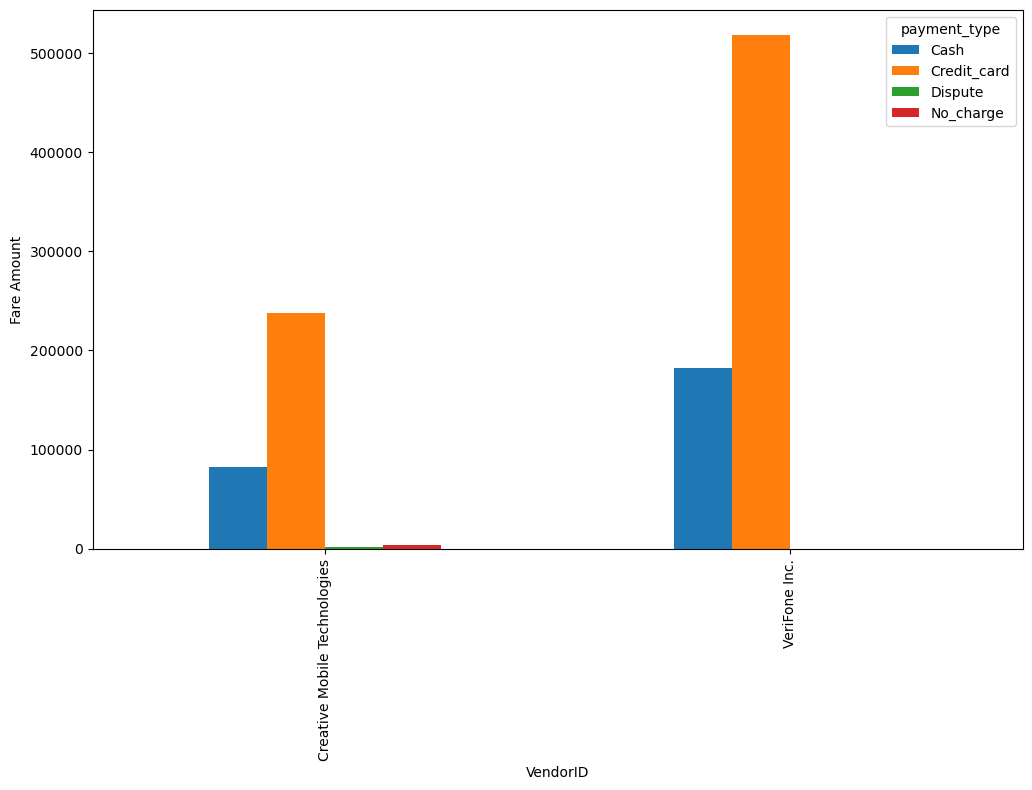

In [48]:
ax = df2.plot.bar(figsize=(12, 7), ylabel='Fare Amount')
plt.show()

> **`Credit card` remains the dominant way of paying which is followed by `Cash`. `Dispute` and `No_charge` are conflicts that are resolved by the cab driver and passenger.**

In [49]:
df3 = df1.groupby(['VendorID','store_and_fwd_flag'])['total_amount'].median().unstack('store_and_fwd_flag')

In [50]:
df3

store_and_fwd_flag,No,Yes
VendorID,,
Creative Mobile Technologies,13.35,13.55
VeriFone Inc.,13.50,14.80


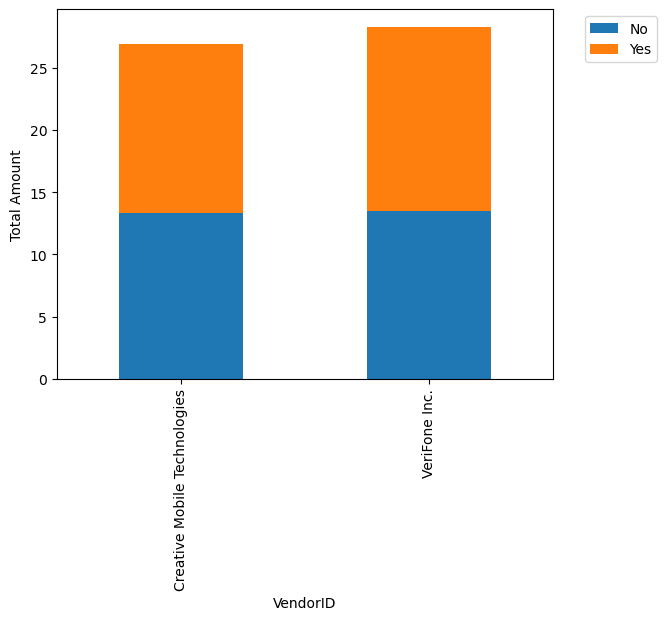

In [51]:
df3.plot.bar(ylabel='Total Amount', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

> **VeriFone Inc. seems to just pass Creative Mobile Technologies by a slight margin in both `Yes` and `No` categories.**

In [52]:
df4 = df1.groupby(['VendorID','RatecodeID'])['total_amount'].median().unstack('RatecodeID')
df4

RatecodeID,Group_ride,JFK,Nassau_or_Westchester,Negotiated_fare,Newark,Other,Standard_rate
VendorID,,,,,,,
Creative Mobile Technologies,3.3,68.92,50.30,24.35,83.67,NaN,13.30
VeriFone Inc.,NaN,69.12,55.36,37.23,84.05,12.8,13.39


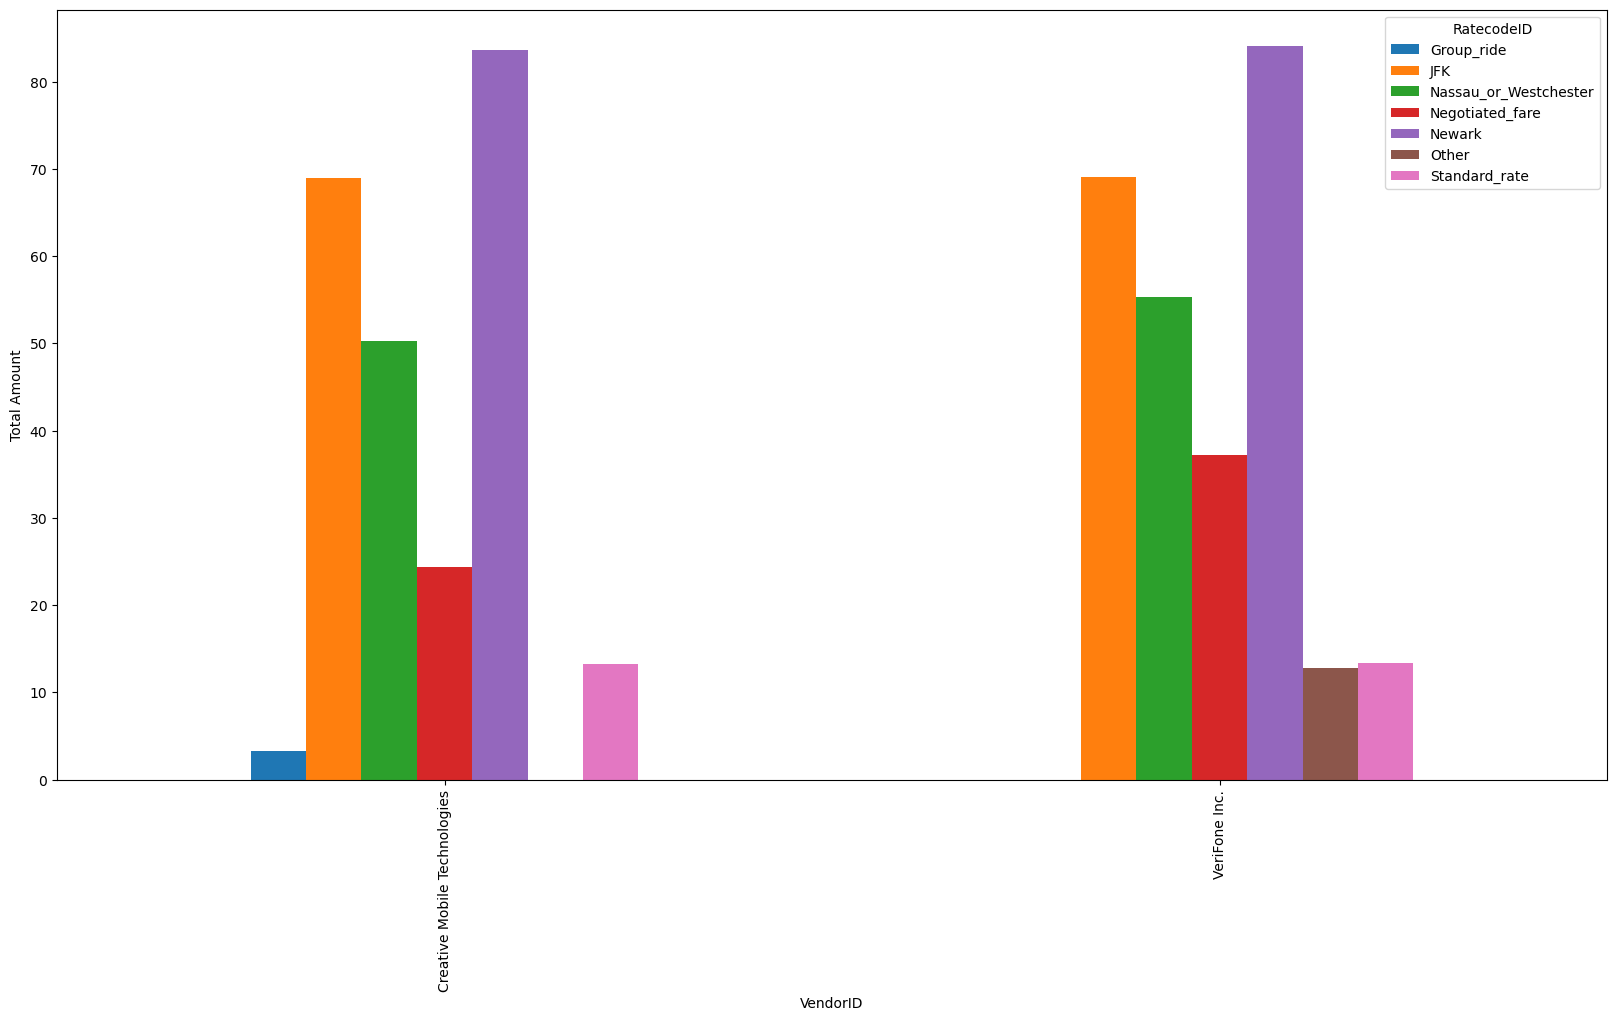

In [53]:
ax = df4.plot.bar(figsize=(20, 10), ylabel='Total Amount')
plt.show()

> **Based on the `RatecodeID`, the pattern for `Total Amount` seems to be similar between the two vendors. However, in some areas, VeriFone Inc surpasses its competitor in `Nassau_or_Westchester` and `Negotiated_Fare`. The category `Other` seems to appear for VeriFone Inc. while `Group_Ride` only appears for Creative Mobile Technologies.**

In [54]:
df5 = df1.groupby(['VendorID'])['total_amount'].sum()
df5

VendorID
Creative Mobile Technologies     5311850.23
VeriFone Inc.                   11525318.14
Name: total_amount, dtype: float64

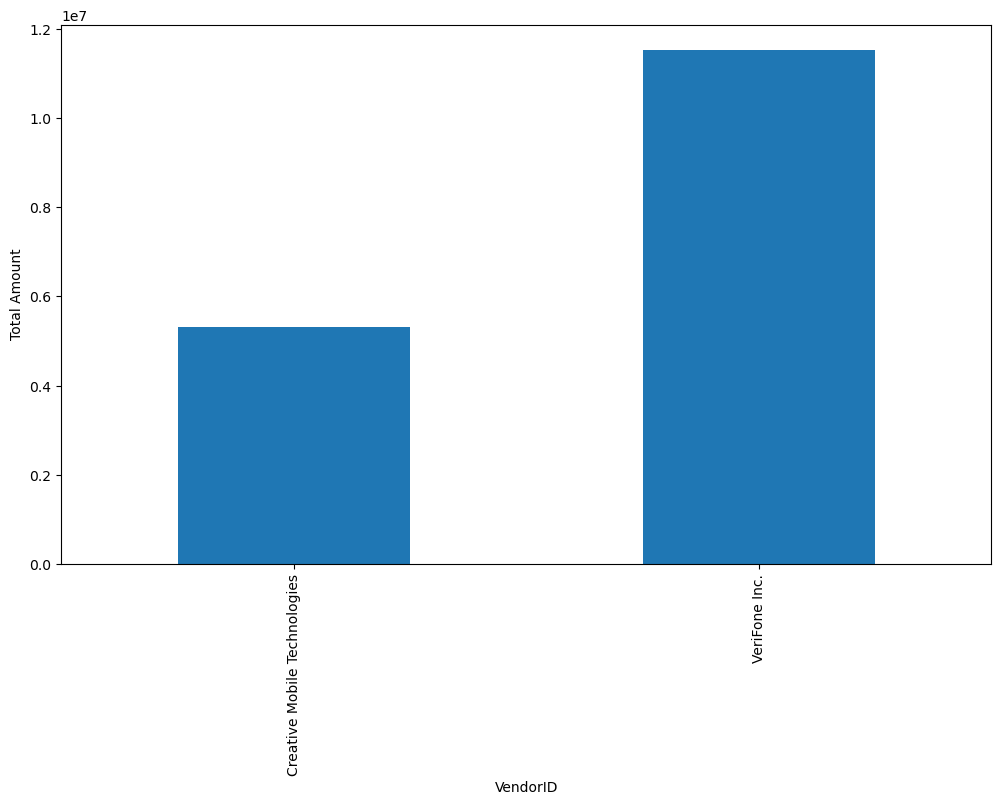

In [55]:
ax = df5.plot.bar(figsize=(12, 7), ylabel='Total Amount')
plt.show()

> **A simple graph showing which of the two vendors had the most money earned. It's quite clear that VeriFone Inc. takes the lead.**

<AxesSubplot:>

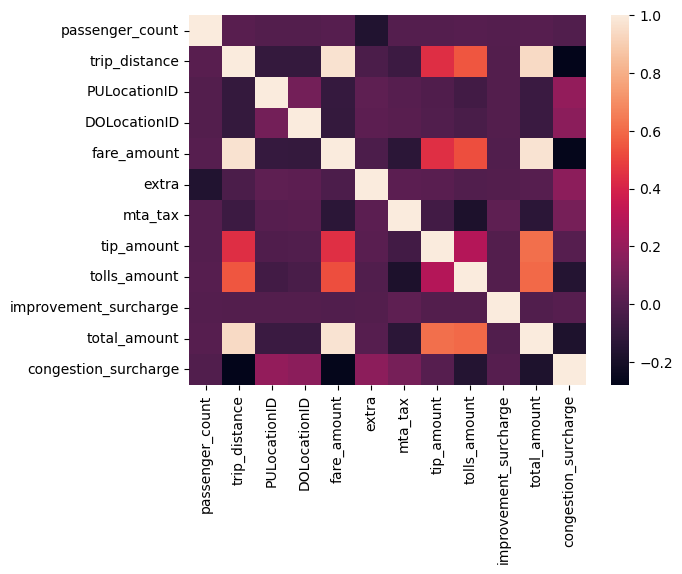

In [56]:
# A correlation heatmap of the normalized dataset
corr = df1.corr(method='pearson')
sb.heatmap(corr)

In [57]:
corr

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
passenger_count,1.000000,0.013054,-0.002942,-0.002084,0.011082,-0.166929,0.003534,0.002781,0.007589,0.002122,0.010592,-0.004686
trip_distance,0.013054,1.000000,-0.102091,-0.101049,0.965216,-0.024965,-0.074757,0.437876,0.546146,-0.001692,0.943622,-0.278345
PULocationID,-0.002942,-0.102091,1.000000,0.099544,-0.098008,0.036133,0.008426,-0.013530,-0.055599,0.000175,-0.079052,0.194389
DOLocationID,-0.002084,-0.101049,0.099544,1.000000,-0.101912,0.027519,0.014445,-0.005790,-0.032322,-0.001478,-0.079397,0.171010
fare_amount,0.011082,0.965216,-0.098008,-0.101912,1.000000,-0.023238,-0.132184,0.443861,0.529756,-0.007694,0.972555,-0.267958
extra,-0.166929,-0.024965,0.036133,0.027519,-0.023238,1.000000,0.025528,0.017778,-0.008290,0.001002,0.010374,0.174445
mta_tax,0.003534,-0.074757,0.008426,0.014445,-0.132184,0.025528,1.000000,-0.054166,-0.181366,0.035402,-0.131101,0.108380
tip_amount,0.002781,0.437876,-0.013530,-0.005790,0.443861,0.017778,-0.054166,1.000000,0.290200,0.001028,0.613708,0.008060
tolls_amount,0.007589,0.546146,-0.055599,-0.032322,0.529756,-0.008290,-0.181366,0.290200,1.000000,-0.000820,0.599310,-0.153907
improvement_surcharge,0.002122,-0.001692,0.000175,-0.001478,-0.007694,0.001002,0.035402,0.001028,-0.000820,1.000000,-0.005940,0.007117


**The correlation matrix shows us how each features is correlated with one another. The lighter the shade, the higher the correlation.** 
> ❗ **For example:** A feature such as `total_amount` seems to have a moderate correlation with features `tip_amount` and `tolls_amount`. The features that have the highest correlation are `trip_distance` and `fare_amount` which makes sense as these are highly dependent on the distance a passenger travels and the cost of the fare. The least correlated features are `congestion_surcharge`, 'pickup and drop off location IDs', `mta_tax`, `extra`, and `improvement_surcharge`. It really comes down to `trip_distance` and `fare_amount` as they are highly correlated, which affect the total amount a passenger is to pay.

### 🔎 **Let's explore and take a deeper dive into the dataset to find out additional information.**

In [58]:
# Setting the datetime columns 
df_EDA['tpep_pickup_datetime']=pd.to_datetime(df_EDA['tpep_pickup_datetime'])
df_EDA['tpep_dropoff_datetime']=pd.to_datetime(df_EDA['tpep_dropoff_datetime'])

In [59]:
# Adding two additional columns to find the pickup hour and dropoff hour
#df_EDA['pickup_hr'] = pd.to_datetime(df_EDA['tpep_pickup_datetime']).dt.hour
df_EDA['Hour'] = pd.to_datetime(df_EDA['tpep_dropoff_datetime']).dt.hour

In [60]:
# Added a day category column to break up the dense data into sections so its easier to understand
df_EDA['Day_Category'] = pd.cut(df_EDA['Hour'], # should be pickup_hr, but this column is causing issues where all the values are 0. 
                    bins=(0,4,8,12,16,20,24), 
                    include_lowest=True,
                    labels=['VE','MC','DT', 'AC','E', 'LN'])

# SE = Very Early (0-4)
# MC = Morning Commute (4-8)
# DT = Day Time (8-12)
# AC = Afternoon Commute (12-16)
# E = Evening (16-20)
# LN = Late Night (20-24)

In [61]:
# Added a date column to just get the date of the month
df_EDA['Date'] = pd.to_datetime(df_EDA['tpep_pickup_datetime']).dt.day

In [62]:
# Added a Weeks column to bin the days into 4 weeks
df_EDA['Weeks'] = pd.cut(df_EDA['Date'], 
                    bins=[1,8,15,22,29], 
                    include_lowest=True, 
                    labels=['Week_1','Week_2','Week_3','Week_4'])

In [63]:
df_EDA.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Hour,Day_Category,Date,Weeks
0,Creative Mobile Technologies,2021-01-01,2021-01-01 00:36:00,1,2.1,Standard_rate,No,142,43,Cash,...,0.5,0.00,0.0,0.3,11.80,2.5,0,VE,1,Week_1
1,Creative Mobile Technologies,2021-01-01,2021-01-01 00:52:00,1,0.2,Standard_rate,No,238,151,Cash,...,0.5,0.00,0.0,0.3,4.30,0.0,0,VE,1,Week_1
2,Creative Mobile Technologies,2021-01-01,2021-01-01 01:11:00,1,14.7,Standard_rate,No,132,165,Credit_card,...,0.5,8.65,0.0,0.3,51.95,0.0,1,VE,1,Week_1


C:\Users\MGS4T\AppData\Local\Temp\ipykernel_3508\3336727471.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df_EDA['trip_distance'])


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

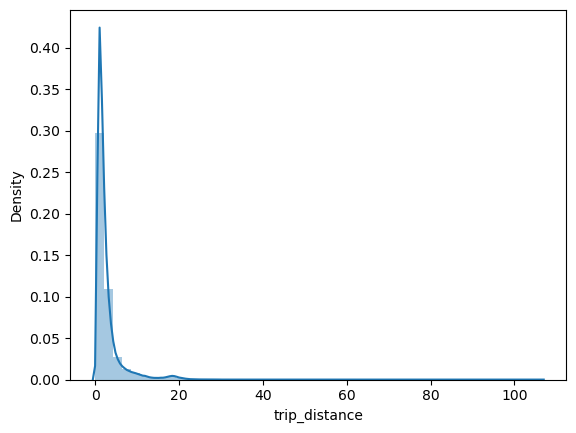

In [64]:
sb.distplot(df_EDA['trip_distance'])

> **The above plot shows that it is heavily left skewed with several extrene outliers. This indicates that majority of people travel shorter distances, but ocassionally people will travel extreme distances.**

C:\Users\MGS4T\AppData\Local\Temp\ipykernel_3508\363734780.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df_EDA['tip_amount'])


<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

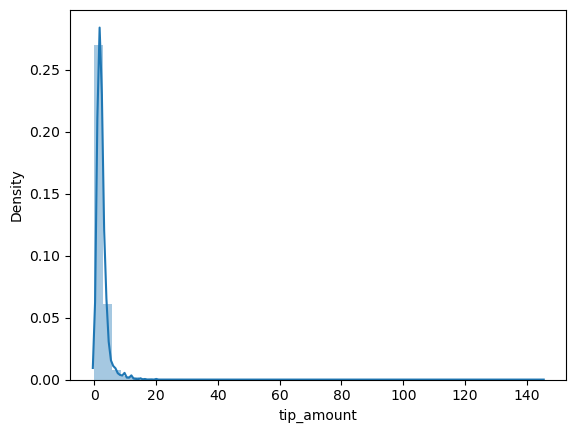

In [65]:
sb.distplot(df_EDA['tip_amount'])

> **The above plot shows that it is heavily left skewed with several extrene outliers. This indicates that majority of people tip in smaller amounts, but ocassionally people will give a large tip.**

C:\Users\MGS4T\AppData\Local\Temp\ipykernel_3508\3414222464.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df_EDA['total_amount'])


<AxesSubplot:xlabel='total_amount', ylabel='Density'>

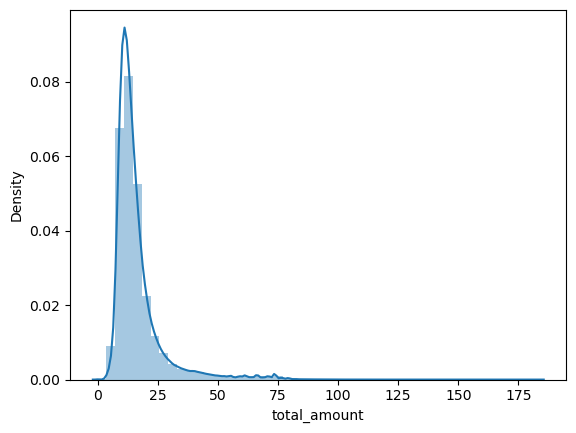

In [66]:
sb.distplot(df_EDA['total_amount'])

> **The above plot shows that it is heavily left skewed with several extrene outliers. This indicates that major earnings are below 50 Dollars USD, but ocassionally the amount can exceed that by quite a lot.**

C:\Users\MGS4T\AppData\Local\Temp\ipykernel_3508\4108767687.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df_EDA['Hour'], kde=True)


<AxesSubplot:xlabel='Hour', ylabel='Density'>

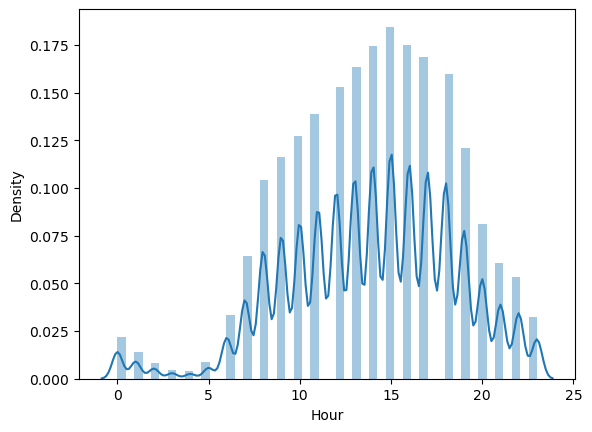

In [67]:
sb.distplot(df_EDA['Hour'], kde=True)

> **This density plot shows which hours of the day are the busiest. The busiest time of day is during the evening when most people are commuting.**

<AxesSubplot:>

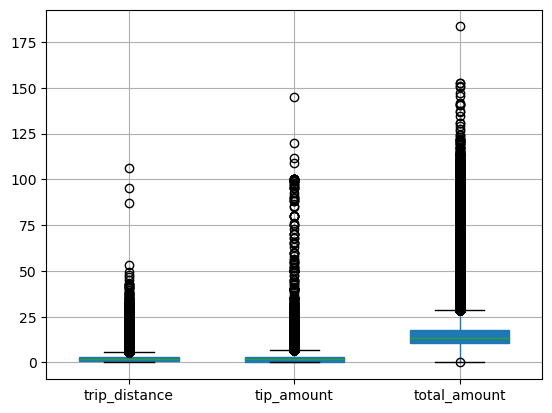

In [68]:
df_EDA.boxplot(column=['trip_distance', 'tip_amount', 'total_amount'], widths = 0.6, patch_artist = True)

> **Here is a great comparison of the three features that seem to be important in the dataset from a higher level point of view. As you can see, all three features have a wide range of outliers. Usually outliers tend to skew the data in the wrong direction which are a result of errors in the data. Errors in a dataset can occur to many different reasons, such as incorrect recording of data. In this dataset, I have checked these outliers in Excel and discovered people tend to travel lengthy distances, pay a higher total cost for their ride due to large distances travelled, and some go as far to tip a large amount as well. Obviously, the majority of passengers don't fall into that category, but there are individuals that do.**

(array([ 20835.,   3978.,  19936., 134677., 125684., 149555., 252138.,
        155263.,  95403.,  68994.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

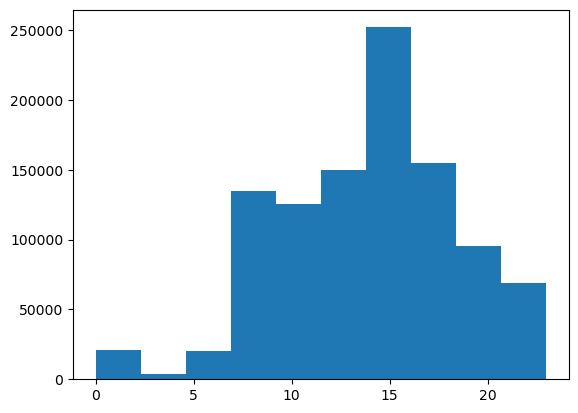

In [69]:
plt.hist(df_EDA['Hour'])

> **This histogram plot also shows the same results as the density plot above as well. It shows that it is more skewed the right with a leading tail on the left. More people seem to be commuting later in the day.**

<Figure size 4000x4000 with 0 Axes>

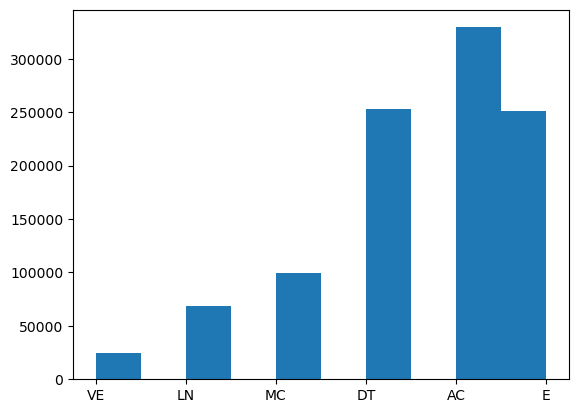

<Figure size 4000x4000 with 0 Axes>

In [70]:
plt.hist(df_EDA['Day_Category'])
plt.figure(figsize=(40,40))

> **Another supporting histogram that shows day to late evening hours are busier than super early and morning hours.**

- SE = Very Early (0-4)
- MC = Morning Commute (4-8)
- DT = Day Time (8-12)
- AC = Afternoon Commute (12-16)
- E = Evening (16-20)
- LN = Late Night (20-24)

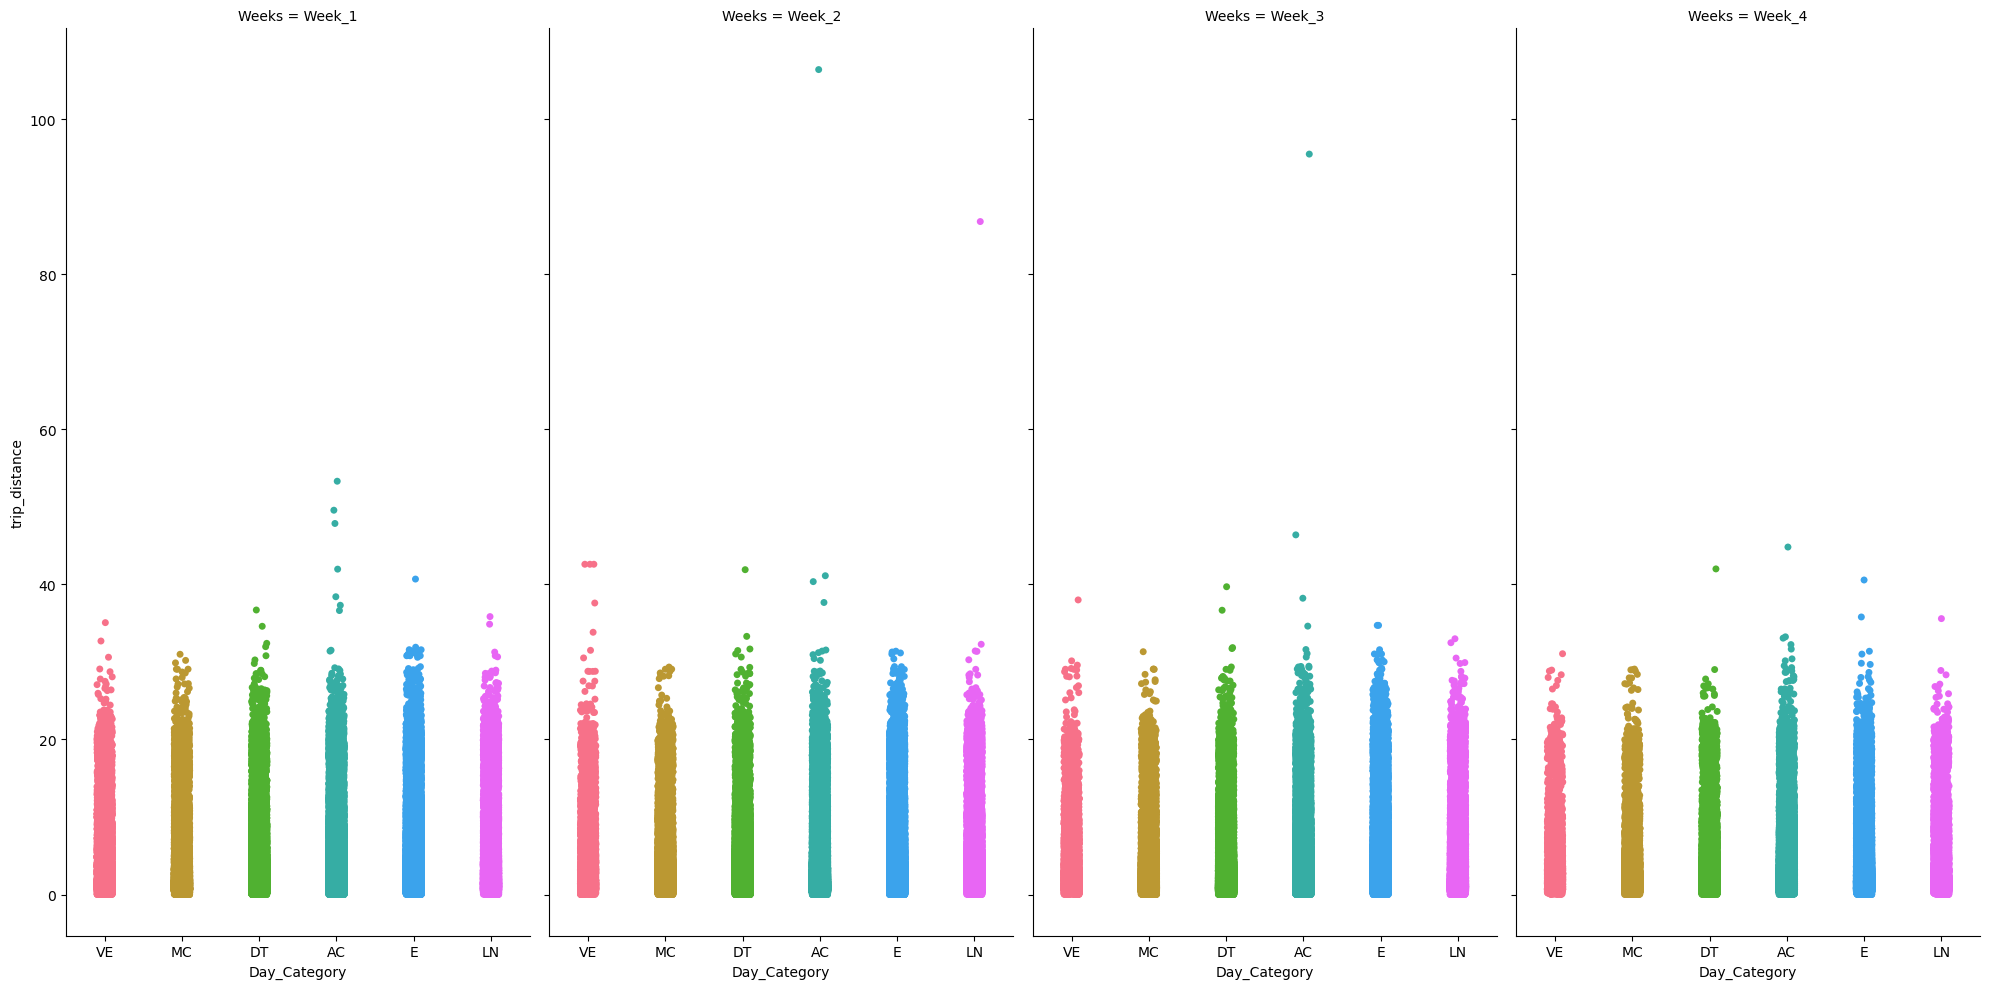

In [71]:
plot1 = sb.catplot(x="Day_Category", y="trip_distance",
                col="Weeks", data=df_EDA, height=10, aspect=0.5, palette="husl", hue="Day_Category")

> **This catplot shows the outliers in each day segment based on the weeks. From looking at the graphs, it appears that week 2 and week 3 seem to have commutes that are further away than most commutes that week, and even greater than in weeks 1 and 4.**

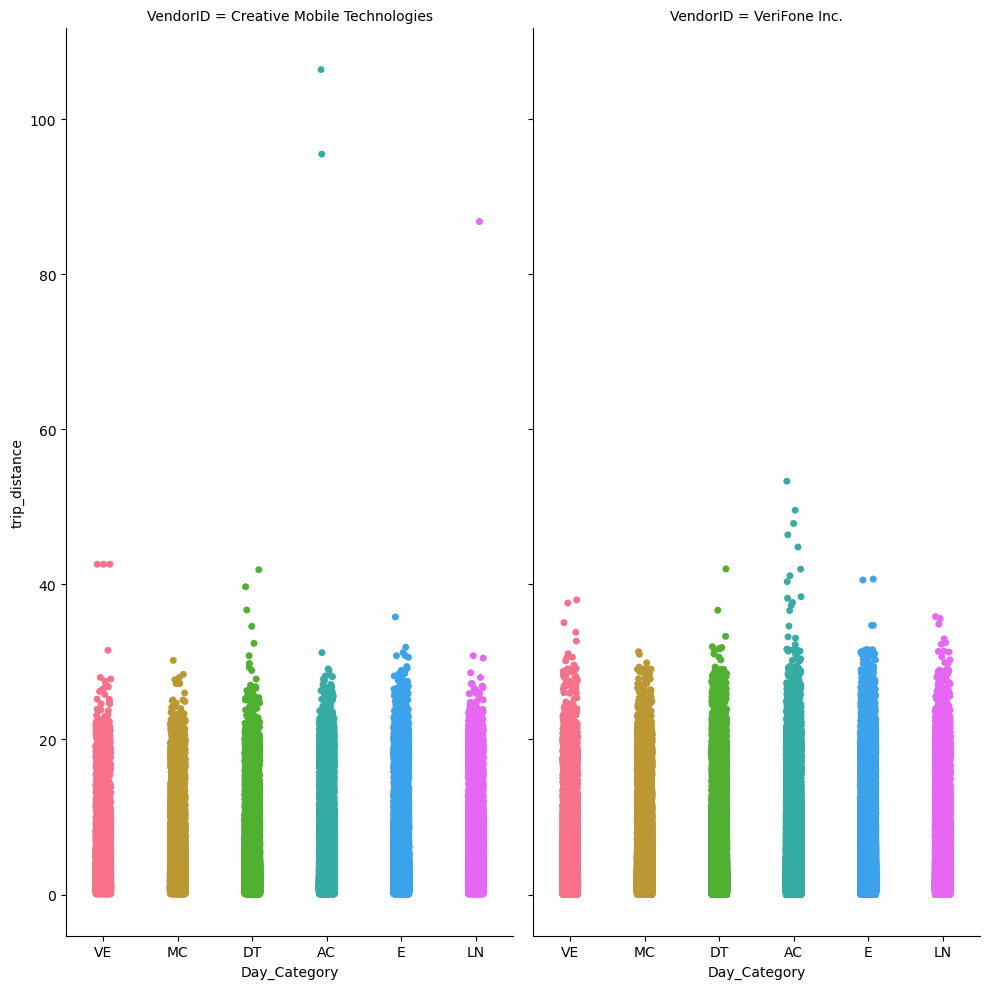

In [72]:
plot2 = sb.catplot(x="Day_Category", y="trip_distance",
                col="VendorID", data=df_EDA, height=10, aspect=0.5, palette="husl", hue="Day_Category")

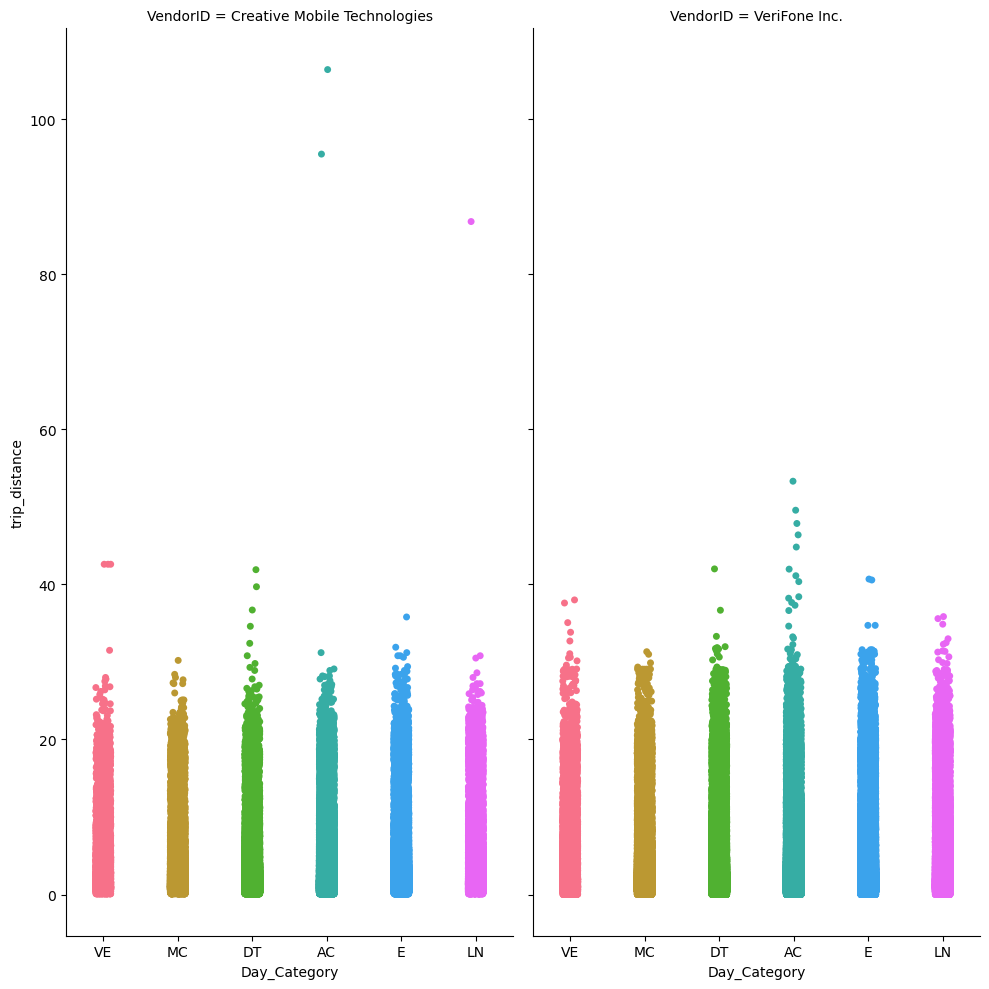

In [73]:
plot3 = sb.catplot(x="Day_Category", y="trip_distance",
                col="VendorID", data=df_EDA, height=10, aspect=0.5, palette="husl", hue="Day_Category")

> **This plot shows vendor ID to day segment comparison. It shows that VendorID=2 seems to have more customers travelling longer distances than VendorID=1 on day categories SE, DT, and AC. VendorID=1 seems to have customers travelling  further  distances for day categories MC and E. Both Vendors have a tie at LN.**

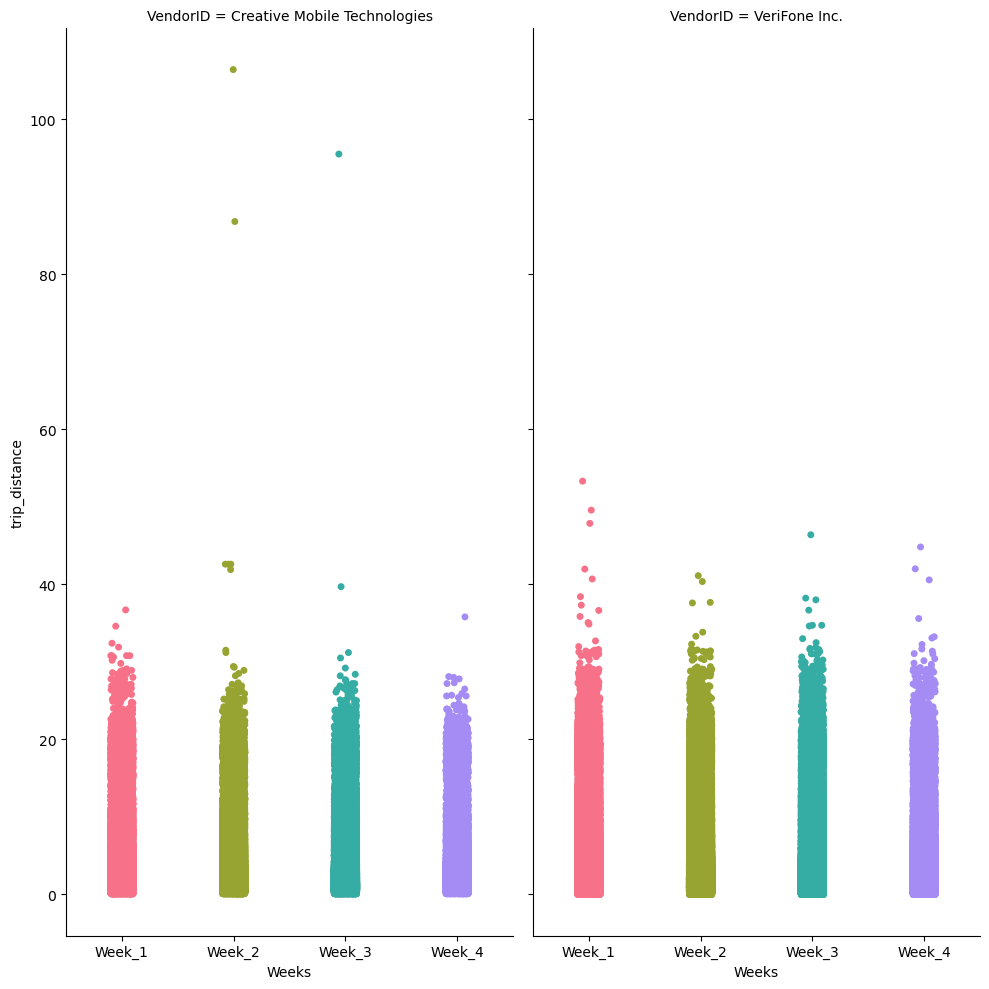

In [74]:
plot4 = sb.catplot(x="Weeks", y="trip_distance",
                col="VendorID", data=df_EDA, height=10, aspect=0.5, palette="husl", hue="Weeks")

> **This last catplot shows a comparison of number of weeks to VendorID. VendorID=2 seems to have a higher number of occurances where customers are willing to travel further distances during Week 1, 2, and 3. VendorID would take the lead in Week 3 and Week 4.**

### 📈 **Time Series Graph for both Vendors in relation to Total_amount**

In [75]:
df_ts = df1.copy()

In [76]:
df_ts

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
VendorID,,,,,,,,,,,,,,,,,
Creative Mobile Technologies,2021-01-01,2021-01-01 0:36,1,2.10,Standard_rate,No,142,43,Cash,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
Creative Mobile Technologies,2021-01-01,2021-01-01 0:52,1,0.20,Standard_rate,No,238,151,Cash,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
Creative Mobile Technologies,2021-01-01,2021-01-01 1:11,1,14.70,Standard_rate,No,132,165,Credit_card,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
Creative Mobile Technologies,2021-01-01,2021-01-01 0:31,0,10.60,Standard_rate,No,138,132,Credit_card,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
VeriFone Inc.,2021-01-01,2021-01-01 0:48,1,4.94,Standard_rate,No,68,33,Credit_card,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VeriFone Inc.,2021-01-26,2021-01-26 19:37,1,1.83,Standard_rate,No,79,234,Credit_card,9.0,1.0,0.5,2.66,0.0,0.3,15.96,2.5
VeriFone Inc.,2021-01-26,2021-01-26 19:46,6,3.81,Standard_rate,No,262,42,Cash,14.5,1.0,0.5,0.00,0.0,0.3,18.80,2.5
VeriFone Inc.,2021-01-26,2021-01-26 20:00,6,0.98,Standard_rate,No,263,262,Credit_card,5.5,1.0,0.5,1.96,0.0,0.3,11.76,2.5


In [77]:
df_ts["tpep_pickup_datetime"] = pd.to_datetime(df_ts["tpep_pickup_datetime"], utc=True)
df_ts["tpep_dropoff_datetime"] = pd.to_datetime(df_ts["tpep_dropoff_datetime"], utc=True)

In [78]:
df_ts['tpep_pickup_datetime'] = df_ts['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')
df_ts['tpep_dropoff_datetime'] = df_ts['tpep_dropoff_datetime'].dt.strftime('%Y-%m-%d')

In [79]:
df_ts1 = df_ts.groupby(['VendorID','tpep_pickup_datetime'])['total_amount'].sum().cumsum().unstack('VendorID')

In [80]:
df_ts1

VendorID,Creative Mobile Technologies,VeriFone Inc.
tpep_pickup_datetime,,
2021-01-01,120368.47,5587835.90
2021-01-02,291849.91,5989409.64
2021-01-03,435858.53,6310515.66
2021-01-04,656143.22,6773400.04
2021-01-05,876588.98,7246277.55
2021-01-06,1102103.22,7739363.34
2021-01-07,1339193.76,8241529.29
2021-01-08,1568038.63,8742905.33
2021-01-09,1750677.35,9166597.90


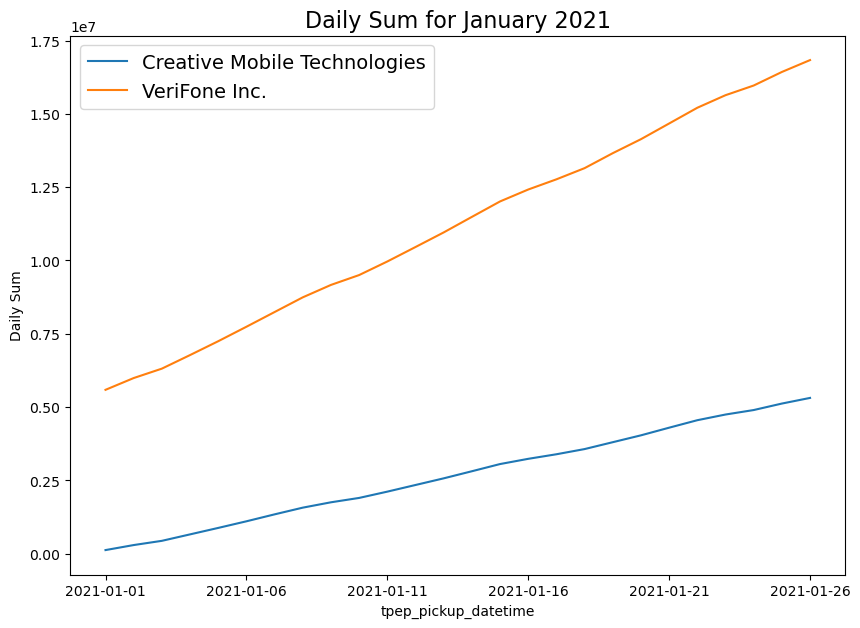

In [81]:
df_ts1.plot(figsize=(10, 7))
plt.ylabel("Daily Sum")
plt.title("Daily Sum for January 2021", fontsize=16)
plt.legend(fontsize=14);

> **This graph shows the Daily Sum for each vendor. It is clear that VeriFone Inc. seems to by earning a lot more than Creative Mobile Technologies.**

# 🔮 **Time Series Prediction Modeling**

In [82]:
df_ts3 = df1.copy()

In [83]:
df_ts3_0 = [y for x, y in df_ts3.groupby('VendorID', as_index=False)]
df_ts3_0 = df_ts3_0[0]

In [84]:
df_ts3_0.head(1)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
VendorID,,,,,,,,,,,,,,,,,
Creative Mobile Technologies,2021-01-01,2021-01-01 0:36,1,2.1,Standard_rate,No,142,43,Cash,8.0,3.0,0.5,0.0,0.0,0.3,11.8,2.5


In [85]:
df_ts3_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326747 entries, Creative Mobile Technologies to Creative Mobile Technologies
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   tpep_pickup_datetime   326747 non-null  object 
 1   tpep_dropoff_datetime  326747 non-null  object 
 2   passenger_count        326747 non-null  int64  
 3   trip_distance          326747 non-null  float64
 4   RatecodeID             326747 non-null  object 
 5   store_and_fwd_flag     326747 non-null  object 
 6   PULocationID           326747 non-null  int64  
 7   DOLocationID           326747 non-null  int64  
 8   payment_type           326747 non-null  object 
 9   fare_amount            326747 non-null  float64
 10  extra                  326747 non-null  float64
 11  mta_tax                326747 non-null  float64
 12  tip_amount             326747 non-null  float64
 13  tolls_amount           326747 non-null  float

In [86]:
#df_ts3_0['tpep_pickup_datetime'] = df_ts3_0['tpep_pickup_datetime'].astype('datetime64')
#df_ts3_0['tpep_dropoff_datetime'] = df_ts3_0['tpep_dropoff_datetime'].astype('datetime64')

In [87]:
df_ts3_0["tpep_pickup_datetime"] = pd.to_datetime(df_ts3_0["tpep_pickup_datetime"], utc=True)
df_ts3_0["tpep_dropoff_datetime"] = pd.to_datetime(df_ts3_0["tpep_dropoff_datetime"], utc=True)

In [88]:
df_ts3_0['tpep_pickup_datetime'] = df_ts3_0['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')
df_ts3_0['tpep_dropoff_datetime'] = df_ts3_0['tpep_dropoff_datetime'].dt.strftime('%Y-%m-%d')

In [89]:
df_ts3_0 = df_ts3_0.groupby(['tpep_pickup_datetime'])['total_amount'].sum().cumsum().reset_index()
df_ts3_0.set_index(['tpep_pickup_datetime'])

,total_amount
tpep_pickup_datetime,
2021-01-01,120368.47
2021-01-02,291849.91
2021-01-03,435858.53
2021-01-04,656143.22
2021-01-05,876588.98
2021-01-06,1102103.22
2021-01-07,1339193.76
2021-01-08,1568038.63
2021-01-09,1750677.35


> **Here we are aggregating the data into a simple table with `datetime` as index and `total_amount` for prediction modeling.**

In [90]:
df_ts3_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tpep_pickup_datetime  26 non-null     object 
 1   total_amount          26 non-null     float64
dtypes: float64(1), object(1)
memory usage: 544.0+ bytes


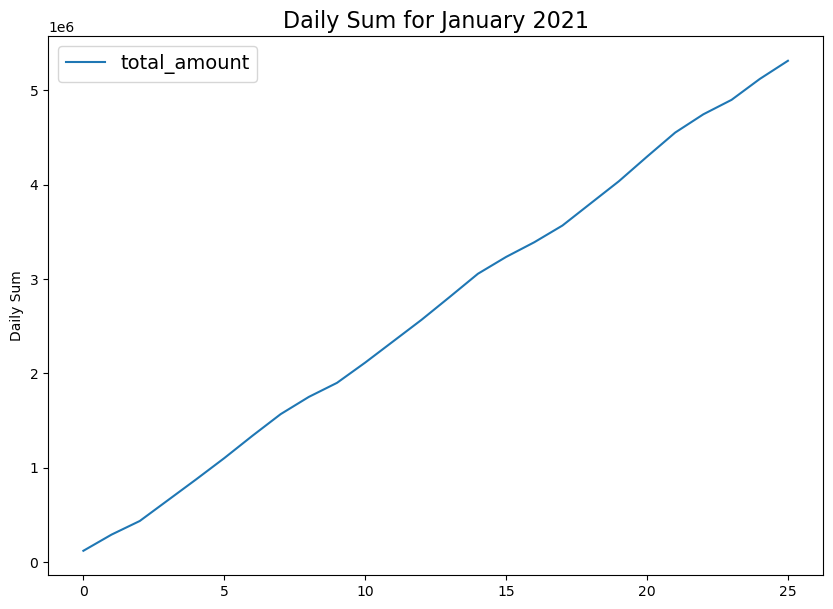

In [91]:
df_ts3_0.plot(figsize=(10, 7))
plt.ylabel("Daily Sum")
plt.title("Daily Sum for January 2021", fontsize=16)
plt.legend(fontsize=14);

> **This graph shows the Daily Sum of both vendors.**

In [92]:
# Get date array
timesteps = df_ts3_0['tpep_pickup_datetime'].to_numpy()
prices = df_ts3_0["total_amount"].to_numpy()

timesteps[:10], prices[:10]

(array(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
        '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
        '2021-01-09', '2021-01-10'], dtype=object),
 array([ 120368.47,  291849.91,  435858.53,  656143.22,  876588.98,
        1102103.22, 1339193.76, 1568038.63, 1750677.35, 1899728.6 ]))

In [93]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(20, 6, 20, 6)

In [94]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Daily Sum")
  locs, labels = plt.xticks()
  plt.setp(labels, rotation=90)
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

### 🩺 **Let's start off by creating a Naive Forecast model. This will be out baseline model which will be used to compare to the results of our other models.**

In [95]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([4296023.72, 4551247.55, 4744973.19, 4897964.08, 5118972.48]),
 array([4296023.72, 4551247.55, 4744973.19, 4897964.08, 5118972.48]))

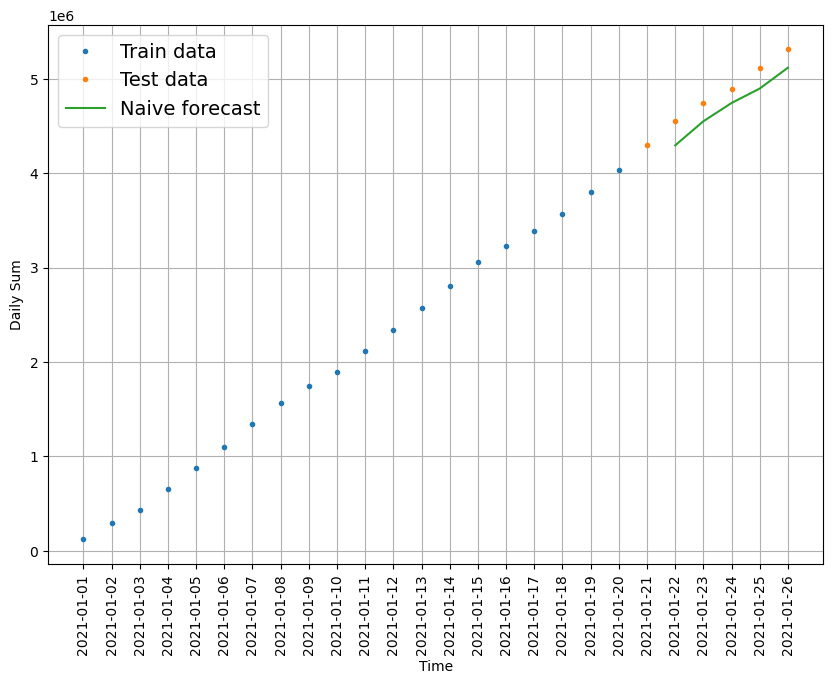

In [96]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

In [97]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [98]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [99]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 203165.3,
 'mse': 42424324000.0,
 'rmse': 205971.66,
 'mape': 4.152523,
 'mase': 1.068444}

In [100]:
# Find average daily earnings in test dataset
tf.reduce_mean(y_test).numpy()

4820171.874999998

- **MAE**: On average, the forcasted earnings are $203,165.30 different than the actual earnings. 
- **MASE**: A value of MASE = 1.068444 indicates that forcast is naive in nature. If the value drops closer to 0, that would mean the model performs better than a Naive Model. 

- **Average Daily Earning**: The average daily earnings is $4,820,171.87

### 🧮 **Our first deep learning model will be a Dense Model. For this, I will use a horizon value of 1 and a window size of 7.**

In [101]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [102]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [103]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [104]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [105]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(19, 19)

In [106]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [ 120368.47  291849.91  435858.53  656143.22  876588.98 1102103.22
 1339193.76] -> Label: [1568038.63]
Window: [ 291849.91  435858.53  656143.22  876588.98 1102103.22 1339193.76
 1568038.63] -> Label: [1750677.35]
Window: [ 435858.53  656143.22  876588.98 1102103.22 1339193.76 1568038.63
 1750677.35] -> Label: [1899728.6]


In [107]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [3389279.21 3566493.49 3801001.57 4035203.08 4296023.72 4551247.55
 4744973.19] -> Label: [4897964.08]
Window: [3566493.49 3801001.57 4035203.08 4296023.72 4551247.55 4744973.19
 4897964.08] -> Label: [5118972.48]
Window: [3801001.57 4035203.08 4296023.72 4551247.55 4744973.19 4897964.08
 5118972.48] -> Label: [5311850.23]


In [108]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [109]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(15, 4, 15, 4)

In [110]:
train_windows[:5], train_labels[:5]

(array([[ 120368.47,  291849.91,  435858.53,  656143.22,  876588.98,
         1102103.22, 1339193.76],
        [ 291849.91,  435858.53,  656143.22,  876588.98, 1102103.22,
         1339193.76, 1568038.63],
        [ 435858.53,  656143.22,  876588.98, 1102103.22, 1339193.76,
         1568038.63, 1750677.35],
        [ 656143.22,  876588.98, 1102103.22, 1339193.76, 1568038.63,
         1750677.35, 1899728.6 ],
        [ 876588.98, 1102103.22, 1339193.76, 1568038.63, 1750677.35,
         1899728.6 , 2114317.45]]),
 array([[1568038.63],
        [1750677.35],
        [1899728.6 ],
        [2114317.45],
        [2340958.62]]))

In [111]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [112]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [113]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of daily sum
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 3272271.5000 - mae: 3272271.5000 - val_loss: 5165235.0000 - val_mae: 5165235.0000
Epoch 2/100
1/1 [==============================] - 0s 367ms/step - loss: 3009772.7500 - mae: 3009772.7500 - val_loss: 4677529.0000 - val_mae: 4677529.0000
Epoch 3/100
1/1 [==============================] - 0s 370ms/step - loss: 2754503.2500 - mae: 2754503.2500 - val_loss: 4188309.5000 - val_mae: 4188309.5000
Epoch 4/100
1/1 [==============================] - 0s 366ms/step - loss: 2492212.7500 - mae: 2492212.7500 - val_loss: 3691467.5000 - val_mae: 3691467.5000
Epoch 5/100
1/1 [==============================] - 0s 359ms/step - loss: 2229205.0000 - mae: 2229205.0000 - val_loss: 3186240.0000 - val_mae: 3186240.0000
Epoch 6/100
1/1 [==============================] - 1s 567ms/step - loss: 1973798.5000 - mae: 1973798.5000 - val_loss: 2686484.5000 - val_mae: 2686484.5000
Epoch 7/100
1/1 [==============================] - 0s 365ms/step - loss: 

In [114]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 15ms/step - loss: 153520.7500 - mae: 153520.7500


[153520.75, 153520.75]

In [115]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 67ms/step - loss: 45725.2500 - mae: 45725.2500


[45725.25, 45725.25]

In [116]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [117]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

1/1 [==============================] - 0s 51ms/step


(4,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([4637937. , 4890666. , 5128511.5, 5370878. ], dtype=float32)>)

In [118]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 45725.25,
 'mse': 3771316200.0,
 'rmse': 61411.043,
 'mape': 0.9255936,
 'mase': 0.24198504}

In [119]:
naive_results

{'mae': 203165.3,
 'mse': 42424324000.0,
 'rmse': 205971.66,
 'mape': 4.152523,
 'mase': 1.068444}

> **You can see that there is a massive improvement in the performance of our simple Dense model.** The **MAE** improved to $45,725.25. The **MASE** value also improved to 0.24198504. Which is much closer to 0 rather than 1.  Even though I would like to see **MAE** decrease rather than increase, **MASE** value brings confidence that there is an improvement over the Naive model. Model_1 still performs well. 

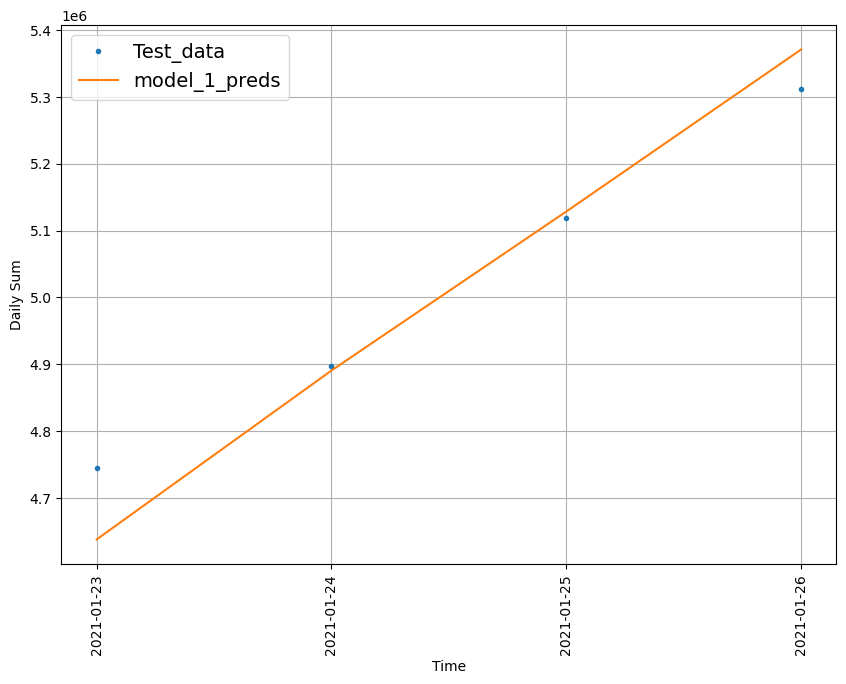

In [120]:
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

> **As you can see, the prediction values are very close to the actual values.** 

### 🧮 **Let's make another Dense model. This time make Window_Size = 10.**

In [121]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 10 # use 30 timesteps in the past

In [122]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(16, 16)

In [123]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(12, 4, 12, 4)

In [124]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


In [125]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 14ms/step - loss: 65962.6250


65962.625

In [126]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 55ms/step - loss: 36107.3750


36107.375

In [127]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

1/1 [==============================] - 0s 33ms/step


In [128]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 36107.375,
 'mse': 2586236200.0,
 'rmse': 50855.05,
 'mape': 0.7328747,
 'mase': 0.19108577}

> **The results for this model show that it performed better than our Dense Model_1. This is the best performing model so far.** The **MASE** value decreased to 0.19108577 and the **MAE** value decreased to $36,107.375.  

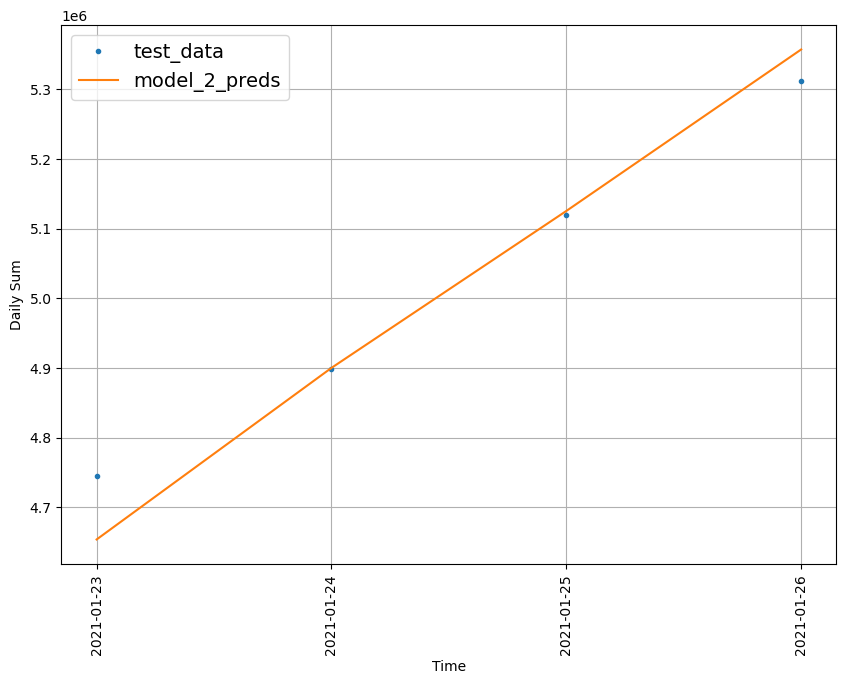

In [129]:
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],  label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, format="-", label="model_2_preds") 

> **Very similar result to Dense Model_1 with slight improvement as it tries to closely match predicted values to the actual values.**

### 🧮 **The second deep learning model will be a Conv1D model. For this, I will set the Horizon = 1 and Window_Size = 7**

In [130]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [131]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(19, 19)

In [132]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(15, 4, 15, 4)

In [133]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [134]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[ 120368.47]
 [ 291849.9 ]
 [ 435858.53]
 [ 656143.25]
 [ 876589.  ]
 [1102103.2 ]
 [1339193.8 ]]


In [135]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_conv1D")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_3.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_conv1D\assets


In [136]:
# Load in best performing Conv1D model and evaluate it on the test data
model_3 = tf.keras.models.load_model("model_experiments/model_3_conv1D")
model_3.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 70ms/step - loss: 73098.0000


73098.0

In [137]:
# Make predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:10]

1/1 [==============================] - 0s 51ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([4667772. , 4928031. , 5180047. , 5435899.5], dtype=float32)>

In [138]:
# Evaluate predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 73098.0,
 'mse': 6495598000.0,
 'rmse': 80595.27,
 'mape': 1.4423274,
 'mase': 0.38684583}

> **Conv1D Model_3 did not perform as hoped but it also didn't that badly either.** The values for **MAE** increased to $73,098.00 and **MASE** increased to 0.38684583. **Model_3** performed **worse** than **Model_1** and **Model_2**, due to the increase in **MAE** and **MASE** values and because this is a **Conv1D Model.** Yet, this model is still good due to the lower **MASE** value, despite having a larger **MAE** value. 

### 🧮 **Conv1D Model 3_5 has an increased number of hidden units. I've changed the hyperparameter to see if there is an improvement over Conv1D Model 3.**

In [139]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [140]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(19, 19)

In [141]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(15, 4, 15, 4)

In [142]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [143]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[ 120368.47]
 [ 291849.9 ]
 [ 435858.53]
 [ 656143.25]
 [ 876589.  ]
 [1102103.2 ]
 [1339193.8 ]]


In [144]:
tf.random.set_seed(42)

# Create model
model_3_5 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=200, kernel_size=5, padding="causal", activation="relu"),
  layers.Conv1D(filters=200, kernel_size=5, padding="causal", activation="relu"),
  layers.Conv1D(filters=200, kernel_size=5, padding="causal", activation="relu"),
  layers.Conv1D(filters=200, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_5_conv1D")

# Compile model
model_3_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_3_5.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3_5.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_5_conv1D\assets


In [145]:
# Load in best performing Conv1D model and evaluate it on the test data
model_3_5 = tf.keras.models.load_model("model_experiments/model_3_5_conv1D")
model_3_5.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 85ms/step - loss: 54050.8750


54050.875

In [146]:
# Make predictions
model_3_5_preds = make_preds(model_3_5, test_windows)
model_3_5_preds[:10]

1/1 [==============================] - 0s 68ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([4680302. , 4938684.5, 5162697.5, 5378937. ], dtype=float32)>

In [147]:
# Evaluate predictions
model_3_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_5_preds)
model_3_5_results

{'mae': 54050.875,
 'mse': 3063259600.0,
 'rmse': 55346.723,
 'mape': 1.0778643,
 'mase': 0.28604552}

> **Model_3_5 performs similarily to Model_1**. The **MAE** value is $54,050.875 and **MASE** value is 0.28604552. Looks like increasing the number of layers and hidden units, also known as hyperparameter tunining, has increased the performance of the model close to **Model_1**. This is a big improvement over **Model_3**. An interesting thing to note here is that with a **Dense Model**, you can have similar performance and results with fewer hidden units and layers when compared to a **Conv1D Model** with more hidden units and layers. **At least in this experiment.**

### 🧮 **The next mode will be a LSTM model. Same as before, Horizon = 1 and Window_Size = 7**

In [148]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape -- Layer!!
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
x = layers.Dense(32, activation="relu")(x) # Layer!!
output = layers.Dense(HORIZON)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_lstm")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_lstm\assets


In [149]:
# Load in best version of model 5 and evaluate on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_lstm/")
model_4.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 173ms/step - loss: 97050.0000


97050.0

In [150]:
# Make predictions with our LSTM model
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

1/1 [==============================] - 0s 149ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([4843747.5, 5120832.5, 5055305.5, 5314740. ], dtype=float32)>

In [151]:
# Evaluate model 5 preds
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 97050.0,
 'mse': 15872153000.0,
 'rmse': 125984.73,
 'mape': 1.9825115,
 'mase': 0.5136035}

> **The LSTM model performed closer to the Model_3.** It has a **MAE** value of $97,050.00 and **MASE** value of 0.5136035. Not a well performing model at all, compared to others. 

### 🧮 **For LSTM Model_4_5, I've increased the number of hidden units and added 1 additional Dense LSTM layers. Let's see what the performance will be over LSTM Model_4.**

In [154]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(200, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape -- Layer!!
x = layers.LSTM(200, activation="relu")(x) # using the tanh loss function results in a massive error
x = layers.Dense(64, activation="relu")(x) # Layer!!
x = layers.Dense(64, activation="relu")(x) # Layer!!
output = layers.Dense(HORIZON)(x)
model_4_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_5_lstm")

# Compile model
model_4_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_4_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4_5.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_5_lstm\assets


In [155]:
# Load in best version of model 5 and evaluate on the test data
model_4_5 = tf.keras.models.load_model("model_experiments/model_4_5_lstm/")
model_4_5.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 173ms/step - loss: 46997.8750


46997.875

In [156]:
# Make predictions with our LSTM model
model_4_5_preds = make_preds(model_4_5, test_windows)
model_4_5_preds[:10]

1/1 [==============================] - 0s 158ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([4651076.5, 4918255. , 5151976. , 5271049.5], dtype=float32)>

In [157]:
# Evaluate model 5 preds
model_4_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_5_preds)
model_4_5_results

{'mae': 46997.875,
 'mse': 2995547400.0,
 'rmse': 54731.594,
 'mape': 0.9514923,
 'mase': 0.24871996}

> **Model_4_5 definetly improved over Model_4.** By adding an additional Dense layer and increasing the number of hidden units, the results of this model are closer to **Model_1**. The **MAE** value is $46,997.875 and **MAE** is 0.24871996. With minor hyperparameter tuning, this results of this model improved nicely

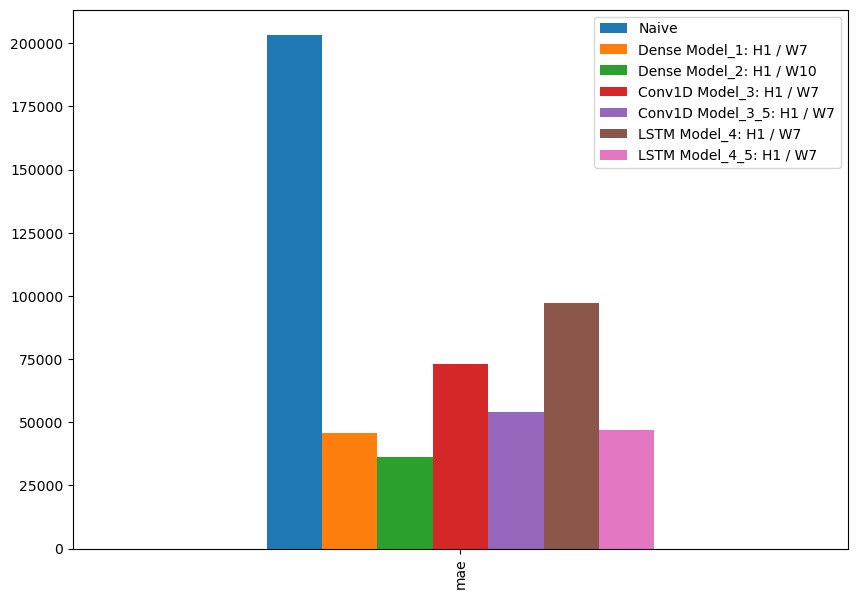

In [158]:
pd.DataFrame({"Naive": naive_results["mae"], 
              "Dense Model_1: H1 / W7": model_1_results["mae"], 
              "Dense Model_2: H1 / W10": model_2_results["mae"],
              "Conv1D Model_3: H1 / W7": model_3_results["mae"],
              "Conv1D Model_3_5: H1 / W7": model_3_5_results["mae"],
              "LSTM Model_4: H1 / W7": model_4_results["mae"],
              "LSTM Model_4_5: H1 / W7": model_4_5_results["mae"],}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

> **This graph shows different models compared to each other based on the MAE value. Each model is based on their Horizon and Window Size**
> 
> - **Naive Model performs the worst as its soley predicting on previous data without learning patterns within the dataset. Due to this, it is unable to reliably generalize**
> - **Model_2 seems to outperform all other models** 
> - **Model 4 performs the worst out of the other deep learning models. As mentioned previously, improving Model_3 and Model_4 required an increase in the number of hidden units and layers, i.e. Model_3_5 and Model_4_5. With the addition of hyperparameter tuning, the models performance improved drastically, almost reaching Model_1's performance** 
> - **Additional modeling experiments might improve the results such as using Window_Size of 10 for the Conv1D and LSTM experiments including experiments with different neural networks**

### 📅 **Let's try and model some Future Predictions.**

In [159]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [160]:
df_ts3_FP = df1.copy()
df_ts3_FP = df_ts3_FP.reset_index()
df_ts3_FP = [y for x, y in df_ts3_FP.groupby('VendorID', as_index=False)]
df_ts3_FP = df_ts3_FP[0]
df_ts3_FP = df_ts3_FP.drop('VendorID', axis=1)

In [161]:
df_ts3_FP = df_ts3_FP.groupby(['tpep_pickup_datetime'])['total_amount'].sum().cumsum().reset_index()
df_ts3_FP.set_index(['tpep_pickup_datetime'])

,total_amount
tpep_pickup_datetime,
2021-01-01,120368.47
2021-01-02,291849.91
2021-01-03,435858.53
2021-01-04,656143.22
2021-01-05,876588.98
2021-01-06,1102103.22
2021-01-07,1339193.76
2021-01-08,1568038.63
2021-01-09,1750677.35


In [162]:
#df_ts3_FP['tpep_pickup_datetime'] = pd.to_datetime(df_ts3_FP['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df_ts3_FP['tpep_pickup_datetime'] = pd.to_datetime(df_ts3_FP['tpep_pickup_datetime'], format='%Y-%m-%d')

In [163]:
df_ts3_FP = df_ts3_FP[['tpep_pickup_datetime', 'total_amount']]

In [164]:
# The purpose of creating an empty list is so that we can add the predicted values to the actual values into the lists and graph them. 
tpep_pickup_datetime = []
total_amount = []

df_ts3_FP

,tpep_pickup_datetime,total_amount
0,2021-01-01,120368.47
1,2021-01-02,291849.91
2,2021-01-03,435858.53
3,2021-01-04,656143.22
4,2021-01-05,876588.98
5,2021-01-06,1102103.22
6,2021-01-07,1339193.76
7,2021-01-08,1568038.63
8,2021-01-09,1750677.35
9,2021-01-10,1899728.60


In [165]:
tpep_pickup_datetime_col = df_ts3_FP['tpep_pickup_datetime'].tolist()
total_amount_col = df_ts3_FP['total_amount'].tolist()

tpep_pickup_datetime_col[:10], total_amount_col[:10]

([Timestamp('2021-01-01 00:00:00'),
  Timestamp('2021-01-02 00:00:00'),
  Timestamp('2021-01-03 00:00:00'),
  Timestamp('2021-01-04 00:00:00'),
  Timestamp('2021-01-05 00:00:00'),
  Timestamp('2021-01-06 00:00:00'),
  Timestamp('2021-01-07 00:00:00'),
  Timestamp('2021-01-08 00:00:00'),
  Timestamp('2021-01-09 00:00:00'),
  Timestamp('2021-01-10 00:00:00')],
 [120368.47,
  291849.91000000003,
  435858.53,
  656143.22,
  876588.98,
  1102103.22,
  1339193.76,
  1568038.63,
  1750677.3499999999,
  1899728.5999999999])

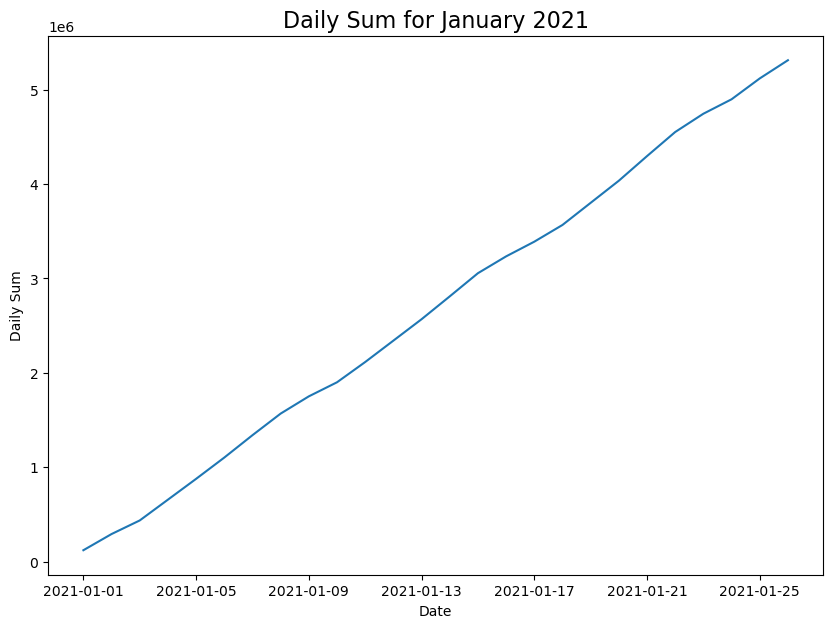

In [166]:
plt.figure(figsize=(10, 7))
plt.plot(tpep_pickup_datetime_col, total_amount_col)
plt.title("Daily Sum for January 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Daily Sum");

In [167]:
tpep_pickup_datetime = list(tpep_pickup_datetime_col)
total_amount = list(total_amount_col)

tpep_pickup_datetime[:10], total_amount[:10]

([Timestamp('2021-01-01 00:00:00'),
  Timestamp('2021-01-02 00:00:00'),
  Timestamp('2021-01-03 00:00:00'),
  Timestamp('2021-01-04 00:00:00'),
  Timestamp('2021-01-05 00:00:00'),
  Timestamp('2021-01-06 00:00:00'),
  Timestamp('2021-01-07 00:00:00'),
  Timestamp('2021-01-08 00:00:00'),
  Timestamp('2021-01-09 00:00:00'),
  Timestamp('2021-01-10 00:00:00')],
 [120368.47,
  291849.91000000003,
  435858.53,
  656143.22,
  876588.98,
  1102103.22,
  1339193.76,
  1568038.63,
  1750677.3499999999,
  1899728.5999999999])

In [168]:
df_ts3_FP = df_ts3_FP.set_index('tpep_pickup_datetime')

In [169]:
# Make a copy of the historical data with block reward feature

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_ts3_FP[f"total_amount+{i+1}"] = df_ts3_FP["total_amount"].shift(periods=i+1)
df_ts3_FP.head(10)

,total_amount,total_amount+1,total_amount+2,total_amount+3,total_amount+4,total_amount+5,total_amount+6,total_amount+7
tpep_pickup_datetime,,,,,,,,
2021-01-01,120368.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,291849.91,120368.47,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,435858.53,291849.91,120368.47,NaN,NaN,NaN,NaN,NaN
2021-01-04,656143.22,435858.53,291849.91,120368.47,NaN,NaN,NaN,NaN
2021-01-05,876588.98,656143.22,435858.53,291849.91,120368.47,NaN,NaN,NaN
2021-01-06,1102103.22,876588.98,656143.22,435858.53,291849.91,120368.47,NaN,NaN
2021-01-07,1339193.76,1102103.22,876588.98,656143.22,435858.53,291849.91,120368.47,NaN
2021-01-08,1568038.63,1339193.76,1102103.22,876588.98,656143.22,435858.53,291849.91,120368.47
2021-01-09,1750677.35,1568038.63,1339193.76,1102103.22,876588.98,656143.22,435858.53,291849.91


In [170]:
df_ts3_FP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2021-01-01 to 2021-01-26
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_amount    26 non-null     float64
 1   total_amount+1  25 non-null     float64
 2   total_amount+2  24 non-null     float64
 3   total_amount+3  23 non-null     float64
 4   total_amount+4  22 non-null     float64
 5   total_amount+5  21 non-null     float64
 6   total_amount+6  20 non-null     float64
 7   total_amount+7  19 non-null     float64
dtypes: float64(8)
memory usage: 1.8 KB


In [171]:
# Train model on entire data to make prediction for the next day 
X_all = df_ts3_FP.drop(["total_amount"], axis=1).dropna().to_numpy(np.float64) # only want prices, our future model can be a univariate model
y_all = df_ts3_FP.dropna()["total_amount"].to_numpy(np.float64)

In [172]:
X_all.shape

(19, 7)

In [173]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [174]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_5 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_5.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_5.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [175]:
# How many timesteps to predict into the future?
INTO_FUTURE = 20 # data is in daily format, we can predict 5 days into the future

In [176]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [177]:
# Make forecasts into future of daily sum
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_5,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 30ms/step
Predicting on: 
 [4035203.08 4296023.72 4551247.55 4744973.19 4897964.08 5118972.48
 5311850.23] -> Prediction: 4805783.0

1/1 [==============================] - 0s 11ms/step
Predicting on: 
 [4296023.72 4551247.55 4744973.19 4897964.08 5118972.48 5311850.23
 4805783.  ] -> Prediction: 4963758.0

1/1 [==============================] - 0s 11ms/step
Predicting on: 
 [4551247.55 4744973.19 4897964.08 5118972.48 5311850.23 4805783.
 4963758.  ] -> Prediction: 5127360.0

1/1 [==============================] - 0s 12ms/step
Predicting on: 
 [4744973.19 4897964.08 5118972.48 5311850.23 4805783.   4963758.
 5127360.  ] -> Prediction: 5305122.0

1/1 [==============================] - 0s 12ms/step
Predicting on: 
 [4897964.08 5118972.48 5311850.23 4805783.   4963758.   5127360.
 5305122.  ] -> Prediction: 5435458.0

1/1 [==============================] - 0s 12ms/step
Predicting on: 
 [5118972.48 5311850.23 4805783.   4963758.   5127360.   530512

In [178]:
future_forecast[:14]

[4805783.0,
 4963758.0,
 5127360.0,
 5305122.0,
 5435458.0,
 5490840.5,
 5460809.5,
 5426509.0,
 5560742.5,
 5698058.0,
 5818840.0,
 5881443.0,
 5905342.0,
 5939805.5]

In [179]:
def get_future_dates(start_date, into_future, offset=2):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [180]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = df_ts3_FP.index[-1]
last_timestep

Timestamp('2021-01-26 00:00:00')

In [181]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31',
       '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
       '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08',
       '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
       '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16'],
      dtype='datetime64[D]')

In [182]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, total_amount[-1])
next_time_steps, future_forecast

(array(['2021-01-26', '2021-01-28', '2021-01-29', '2021-01-30',
        '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
        '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
        '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
        '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15',
        '2021-02-16'], dtype='datetime64[D]'),
 array([5311850. , 4805783. , 4963758. , 5127360. , 5305122. , 5435458. ,
        5490840.5, 5460809.5, 5426509. , 5560742.5, 5698058. , 5818840. ,
        5881443. , 5905342. , 5939805.5, 6022965. , 6141453. , 6247008.5,
        6325877.5, 6378887.5, 6438808. ], dtype=float32))

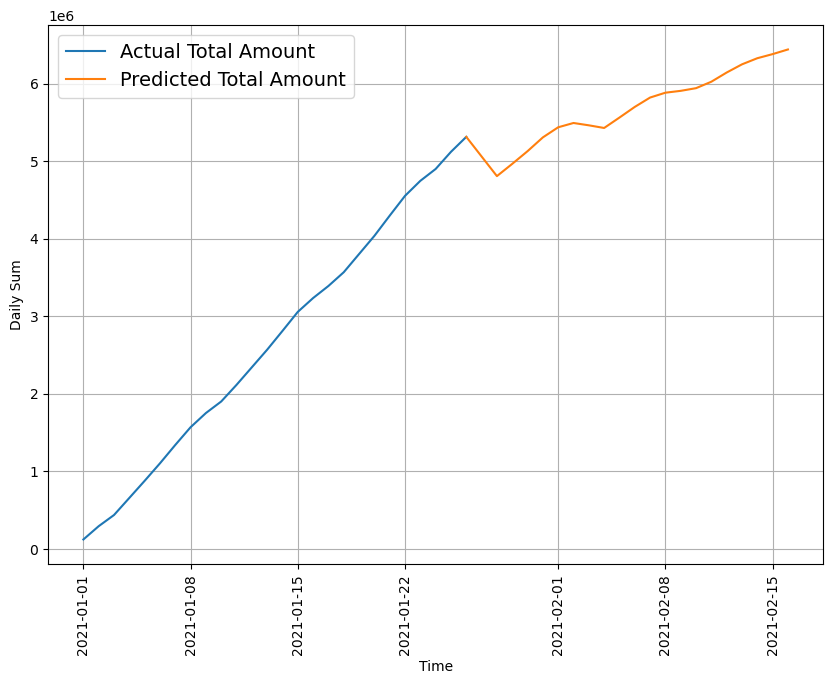

In [183]:
# Plot future price predictions of daily sum
plt.figure(figsize=(10, 7))

plot_time_series(tpep_pickup_datetime, total_amount, format="-", label="Actual Total Amount")

plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted Total Amount")

> **Running the model and graphing its projections indicate that moving into Feburary 2021, the model predicts a steady increase in daily earnings is to be expected.**
> 
> - ❗ **Note:** This uses a regular Dense model as it performed well in previous experiments

### 🧮 **Multivariate Analysis - Without Lag**

In [184]:
df_ts3_0_MV = df1.copy()

df_ts3_0_MV = [y for x, y in df_ts3_0_MV.groupby('VendorID', as_index=False)]
df_ts3_0_MV = df_ts3_0_MV[0]

df_ts3_0_MV["tpep_pickup_datetime"] = pd.to_datetime(df_ts3_0_MV["tpep_pickup_datetime"], utc=True)
df_ts3_0_MV["tpep_dropoff_datetime"] = pd.to_datetime(df_ts3_0_MV["tpep_dropoff_datetime"], utc=True)

df_ts3_0_MV['tpep_pickup_datetime'] = df_ts3_0_MV['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')
df_ts3_0_MV['tpep_dropoff_datetime'] = df_ts3_0_MV['tpep_dropoff_datetime'].dt.strftime('%Y-%m-%d')

df_ts3_0_MV = df_ts3_0_MV.drop(['tpep_dropoff_datetime'], axis=1)
df_ts3_0_MV = df_ts3_0_MV.drop(['RatecodeID'], axis=1)
df_ts3_0_MV = df_ts3_0_MV.drop(['payment_type'], axis=1)
df_ts3_0_MV = df_ts3_0_MV.drop(['store_and_fwd_flag'], axis=1)

#df_ts3_0_MV = df_ts3_0_MV.groupby(['tpep_pickup_datetime'])['total_amount'].sum().cumsum().reset_index()
df_ts3_0_MV = df_ts3_0_MV.set_index(['tpep_pickup_datetime'])

In [185]:
df_ts3_0_MV.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
tpep_pickup_datetime,,,,,,,,,,,,
2021-01-01,1,2.1,142,43,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
2021-01-01,1,0.2,238,151,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2021-01-01,1,14.7,132,165,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
2021-01-01,0,10.6,138,132,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
2021-01-01,1,1.6,224,68,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5


Train_X shape: (8760, 1, 23)
Train_y shape: (8760,)
Test_X shape: (317986, 1, 23)
Test_y Shape: (317986,)
Epoch 1/100
122/122 [==============================] - 10s 70ms/step - loss: 0.2809 - val_loss: 0.1145
Epoch 2/100
122/122 [==============================] - 7s 62ms/step - loss: 0.1518 - val_loss: 0.0888
Epoch 3/100
122/122 [==============================] - 8s 65ms/step - loss: 0.1354 - val_loss: 0.0881
Epoch 4/100
122/122 [==============================] - 8s 68ms/step - loss: 0.1301 - val_loss: 0.0910
Epoch 5/100
122/122 [==============================] - 9s 77ms/step - loss: 0.1292 - val_loss: 0.0900
Epoch 6/100
122/122 [==============================] - 8s 68ms/step - loss: 0.1245 - val_loss: 0.0960
Epoch 7/100
122/122 [==============================] - 8s 65ms/step - loss: 0.1214 - val_loss: 0.1010
Epoch 8/100
122/122 [==============================] - 9s 70ms/step - loss: 0.1167 - val_loss: 0.0944
Epoch 9/100
122/122 [==============================] - 8s 70ms/step - loss: 0

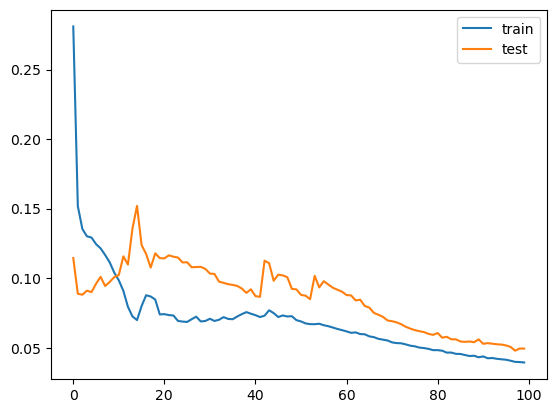

9938/9938 [==============================] - 13s 1ms/step
Test RMSE: 0.623


In [186]:
# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Prepare dataset
values = df_ts3_0_MV.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(f'Train_X shape: {train_X.shape}')
print(f'Train_y shape: {train_y.shape}')
print(f'Test_X shape: {test_X.shape}')
print(f'Test_y Shape: {test_y.shape}')

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -11:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -11:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### 🧮 **Multivariate Analysis - With Lag**

In [187]:
df_ts3_0_MV_lag = df1.copy()

df_ts3_0_MV_lag = [y for x, y in df_ts3_0_MV_lag.groupby('VendorID', as_index=False)]
df_ts3_0_MV_lag = df_ts3_0_MV_lag[0]

df_ts3_0_MV_lag["tpep_pickup_datetime"] = pd.to_datetime(df_ts3_0_MV_lag["tpep_pickup_datetime"], utc=True)
df_ts3_0_MV_lag["tpep_dropoff_datetime"] = pd.to_datetime(df_ts3_0_MV_lag["tpep_dropoff_datetime"], utc=True)

df_ts3_0_MV_lag['tpep_pickup_datetime'] = df_ts3_0_MV_lag['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')
df_ts3_0_MV_lag['tpep_dropoff_datetime'] = df_ts3_0_MV_lag['tpep_dropoff_datetime'].dt.strftime('%Y-%m-%d')

df_ts3_0_MV_lag = df_ts3_0_MV_lag.drop(['tpep_dropoff_datetime'], axis=1)
df_ts3_0_MV_lag = df_ts3_0_MV_lag.drop(['RatecodeID'], axis=1)
df_ts3_0_MV_lag = df_ts3_0_MV_lag.drop(['payment_type'], axis=1)
df_ts3_0_MV_lag = df_ts3_0_MV_lag.drop(['store_and_fwd_flag'], axis=1)

#df_ts3_0_MV = df_ts3_0_MV.groupby(['tpep_pickup_datetime'])['total_amount'].sum().cumsum().reset_index()
df_ts3_0_MV_lag = df_ts3_0_MV_lag.set_index(['tpep_pickup_datetime'])

In [188]:
df_ts3_0_MV_lag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326747 entries, 2021-01-01 to 2021-01-26
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   passenger_count        326747 non-null  int64  
 1   trip_distance          326747 non-null  float64
 2   PULocationID           326747 non-null  int64  
 3   DOLocationID           326747 non-null  int64  
 4   fare_amount            326747 non-null  float64
 5   extra                  326747 non-null  float64
 6   mta_tax                326747 non-null  float64
 7   tip_amount             326747 non-null  float64
 8   tolls_amount           326747 non-null  float64
 9   improvement_surcharge  326747 non-null  float64
 10  total_amount           326747 non-null  float64
 11  congestion_surcharge   326747 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 32.4+ MB


The reframed shape is: (326744, 48)
(8760, 30) 8760 (8760,)
Train_X shape: (8760, 3, 10)
Train_y shape: (8760,)
Test_X shape: (317984, 3, 10)
Test_y Shape: (317984,)
Epoch 1/100
122/122 [==============================] - 10s 79ms/step - loss: 0.2317 - val_loss: 0.2091
Epoch 2/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2153 - val_loss: 0.2093
Epoch 3/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2148 - val_loss: 0.2094
Epoch 4/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2145 - val_loss: 0.2089
Epoch 5/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2144 - val_loss: 0.2089
Epoch 6/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2142 - val_loss: 0.2095
Epoch 7/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2143 - val_loss: 0.2091
Epoch 8/100
122/122 [==============================] - 9s 76ms/step - loss: 0.2144 - val_loss: 0.2079
Epoch 9/100
122/1

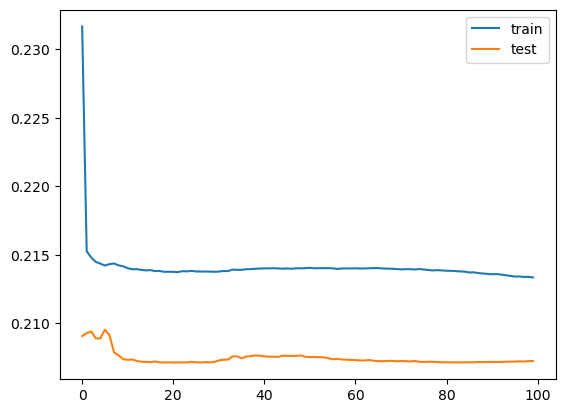

9937/9937 [==============================] - 15s 1ms/step
Test RMSE: 1.487


In [189]:
# Prepare dataset
values = df_ts3_0_MV_lag.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(f"The reframed shape is: {reframed.shape}")
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(f'Train_X shape: {train_X.shape}')
print(f'Train_y shape: {train_y.shape}')
print(f'Test_X shape: {test_X.shape}')
print(f'Test_y Shape: {test_y.shape}')
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -11:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -11:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### 🏁 **Summary of Multivariate Analysis**

We can see that model for **`Multivariate Analysis - Without Lag`** outperformed the **`Multivariate Analysis - With Lag`** model.
- **`Multivariate Analysis - Without Lag`**: Test RMSE: 0.623
- **`Multivariate Analysis - With Lag`**: Test RMSE: 1.487

Even though the numbers look great, the actualy graphs do not show that the model is generalizing properly to the data and that the numbers are bit misleading.
- **Without-Lag**: The loss curve shows a lot of stepping where the model is not able to generalize to the data properly and it shows it struggles. Just around epoch 60, it starts to stabilize and it starts to improve. This shows some level of unrepresentative training data for the loss curves.
- **With-Lag**: The loss cruve doesn't show stepping, but the train and test loss curves are far apart with a higher RMSE value. Just like **Without-Lag**, this too shows a bit of unrepresentative training as well. 


### Without-Lag
In the case of unrepresentative testing dataset (or validation dataset), the testing data is not able to provide the necessary information for the model to generalize on unseen data. This could occur if there isn't enough data for testing. The general pattern that is observed in the loss curves is that the training data seems to improve it's loss while the testing (or validation data) data shows noisy improvements or little or no improvements. In our case, we can see the training data seems to improve over time and that the testing data shows noisy improvements. 

**Solution:**
- To imrpove the loss curves, you can either add more observations to the testing (or validation) data or if limited with the number of observations, you can use cross-validation. Since our model is training and testing on a timeseries dataset, we won't be able to do cross-validation, but we can add more data to improve its loss curves. 

### With-Lag
Unrepresentative training occurs when the training dataset is not able to provide the information needed for the model to understand the problem, as compared to the test (or validation) dataset. Unrepresentative training usually shows that the loss decreases overtime, for both datasets, but there is a large gap between the two curves. The two main reasons why this happens are the following:
- not enough examples in the training dataset as compared to the test (or validation) dataset
- the validation dataset contains a higher variance than the training dataset

**Solution:**
- Normally, you would add more observations, include data augmentation to help increase feature variability in the training data, random sampling (more specifically, stratified sampling), or incorporate cross-validation. The nature of this experiment is based on a time series analysis. It would be difficult to incorporate the aformentioned solutions, except for adding more observations. 

### Next Steps
- The Multivariate Analysis was conducted **with and without lag**. In both experiments, the loss curves were not optimal and struggled to generalize on unseen data or have trouble learning from the training data. Since the model is learning on timeseries data, the next step would be to add previous months, or even years, of data to help improve the loss curves so that the model can learning better from the training data and generalize on unseen data. With additional data, it can improve the results for **with and without lag models.**